### Prediction
Author: Ru Feng and Jenny Empawi

### Motivation
Use gene set expression, show their prediction to disease.

### Implementation
Three models were used **GLMnet** and **GLM**. The steps include: 
1. Process data
2. Split data into train and test
3. Train models
4. Make predictions
5. Calculate AUC and ROC

GRN and Fisher test between xQTL and xQTL only genes were also analyzed. Multigene key regulatory pathway and target network example were also shown in this notebook.

#### Load libraries

In [83]:
library(pROC)
library(ggplot2)
library(caret)
library(data.table)
library(dplyr)
library(tidyverse)
library(stringr)
library(glmnet)
library(igraph)
library(readr)
library(UpSetR)
library(clusterProfiler)
library(org.Hs.eg.db)
library(UpSetR)
library(showtext)
font_add_google("Noto Sans", "Noto Sans")
showtext_auto()

#### Load data

In [84]:
# Load DLPFC expression matrix
exp_raw <- fread('/restricted/projectnb/xqtl/jaempawi/xqtl/DLPFC_samples_list.rnaseqc.gene_tpm.low_expression_filtered.outlier_removed.tmm.expression.remove_duplicates.bed.gz') #FIXME
exp <- exp_raw %>% dplyr::select(-c(1:3)) %>% t()
colnames(exp) <- exp[1,]
exp <- exp[-1,]
exp %>% head

,ENSG00000227232,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000268903,ENSG00000269981,ENSG00000241860,ENSG00000279457,ENSG00000228463,⋯,ENSG00000160285,ENSG00000215424,ENSG00000239415,ENSG00000160294,ENSG00000182362,ENSG00000160298,ENSG00000160299,ENSG00000160305,ENSG00000160307,ENSG00000160310
SM-CTDS5,0.867132226,-0.079551208,-0.084107434,-0.396103081,0.106916690,2.780066152,2.909231171,-0.660305236,1.278460918,0.626789692,⋯,1.985386837,1.050521827,0.229036458,0.102350767,0.349852661,0.840974324,1.074477563,0.306718075,-0.420783689,0.164210777
SM-CJIXK,0.435715059,1.637867795,1.572036748,1.579897094,0.880435950,1.807706619,-0.180342034,-1.595917354,0.511936214,0.509349530,⋯,1.419349658,0.545885091,-0.455776472,-1.004334538,-0.090945078,0.212750290,-1.168131755,-0.388746382,1.283618817,1.000581897
SM-CJGH9,-0.366800123,0.268852127,0.914398963,0.963802551,0.691692537,0.465875879,0.691692537,-0.152714801,1.141593112,0.068167656,⋯,0.860537623,-0.396103081,-0.545885091,-0.572432526,1.090796768,0.668799809,0.735628979,-0.233700639,-0.081829108,0.120628231
SM-CTDS7,0.006811543,-0.182650237,-0.027249331,-0.271206929,0.217397537,0.897288076,0.335406003,0.208107633,0.654668579,-0.231367920,⋯,1.082601126,0.572432526,-0.640666890,0.029520743,1.248203557,0.473481684,-0.045425550,1.099066340,0.805918480,0.643457110
SM-CJGLT,0.268852127,0.208107633,0.890516885,0.935292302,-0.215073333,1.219047704,0.491336588,1.637867795,0.002270499,-0.079551208,⋯,-0.465875879,0.717888423,0.125203661,-1.268245915,1.498289808,1.549020419,-0.473481684,-1.209556091,0.470943393,1.258161561
SM-CTDT7,1.796193374,-0.022706917,-0.113769787,-0.762683499,0.777957272,0.369229698,1.299301209,0.596674624,1.612358004,-0.294840218,⋯,-0.473481684,-1.000581897,-0.674489750,0.450744213,0.009082111,0.378969996,0.559109551,0.583164438,-0.535373943,0.378969996


In [85]:
# Load xQTL list
gene_list <- fread("/restricted/projectnb/xqtl/jaempawi/xqtl/Staging/variant_gene_summary/AD_xQTL_integration_summary/AD_genes_FunGen_AD_GVC_xQTL_20250325.tsv")  #FIXME
xQTL_list <- gene_list %>% filter(str_detect(data_resources, 'FunGen_xQTL'))
xQTL_list %>% head

gene_id,resource_in_FunGen_xQTL,data_resources,chr,start,end,gene_name
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
ENSG00000002919,ColocBoost,FunGen_xQTL,17,48103356,48103357,SNX11
ENSG00000005100,ColocBoost,FunGen_xQTL,17,5468981,5468982,DHX33
ENSG00000006530,ColocBoost,FunGen_xQTL,7,141551277,141551278,AGK
ENSG00000008294,ColocBoost,FunGen_xQTL,17,51120867,51120868,SPAG9
ENSG00000013503,ColocBoost,FunGen_xQTL,12,106357747,106357748,POLR3B
ENSG00000029725,ColocBoost,FunGen_xQTL,17,5282264,5282265,RABEP1


In [86]:
# Load ROSMAP clinical metadata
meta <- fread('/restricted/projectnb/xqtl/jaempawi/xqtl/ROSMAP_clinical_metadata.tsv')
exp_meta <- meta[specimenID %in% rownames(exp), .(specimenID, group)]
exp_meta <- exp_meta[order(match(specimenID, colnames(exp_raw)))]

In [87]:
# Load gvc exp
real_gvc_list <- gene_list %>% filter(str_detect(data_resources, 'ADSP_GVC')) # 20 genes from GVC table2
gvc_exp <- exp_raw %>% filter(gene_id %in% real_gvc_list$gene_id) 
rownames(gvc_exp) <- gvc_exp$gene_id
gvc_exp <- gvc_exp %>% dplyr::select(any_of(exp_meta$specimenID)) %>% t

### Model with glmnet

In [88]:
# Function to process xQTL expression data
process_xQTL_exp <- function(exp_raw, gene_ids, exp_meta) {
  exp_data <- exp_raw %>% 
    filter(gene_id %in% gene_ids) %>% 
    column_to_rownames("gene_id") %>% 
    dplyr::select(any_of(exp_meta$specimenID)) %>% 
    t()
  return(exp_data)
}

# Calculate n_methods and create shared gene sets
xQTL_list <- xQTL_list %>% 
  mutate(n_methods = str_count(resource_in_FunGen_xQTL, ',') + 1)

# Store gene sets for different n_methods thresholds
gene_sets <- list(
  "Gene Set 1" = list(genes = gvc_exp, is_matrix = TRUE),
  "Gene Set 2" = list(genes = xQTL_list$gene_id, is_matrix = FALSE),
  "Gene Set 3" = list(genes = xQTL_list %>% filter(n_methods > 1) %>% pull(gene_id), is_matrix = FALSE),
  "Gene Set 4" = list(genes = xQTL_list %>% filter(n_methods > 2) %>% pull(gene_id), is_matrix = FALSE),
  "Gene Set 5" = list(genes = xQTL_list %>% filter(n_methods > 3) %>% pull(gene_id), is_matrix = FALSE),
  "Gene Set 6" = list(genes = xQTL_list %>% filter(n_methods > 4) %>% pull(gene_id), is_matrix = FALSE)
)

# Prepare labels
labels <- exp_meta %>% 
  mutate(labels = ifelse(group == 'ad', 1, 0)) %>% 
  pull(labels)

# Process datasets and remove near-zero variance predictors
data_list <- lapply(names(gene_sets), function(set_name) {
  if (gene_sets[[set_name]]$is_matrix) {
    data <- data.frame(gvc_exp, Disease = as.factor(labels))
  } else {
    exp_data <- process_xQTL_exp(exp_raw, gene_sets[[set_name]]$genes, exp_meta)
    data <- data.frame(exp_data, Disease = as.factor(labels))
  }
  # Remove near-zero variance predictors
  nzv <- nearZeroVar(data[, -ncol(data)], saveMetrics = TRUE)
  data <- data[, !nzv$zeroVar & !nzv$nzv]
  return(data)
})
names(data_list) <- names(gene_sets)

In [89]:
# Split data into train/test
set.seed(123)
trainIndex <- createDataPartition(labels, p = 0.7, list = FALSE)
train_data <- lapply(data_list, function(data) data[trainIndex, ])
test_data <- lapply(data_list, function(data) data[-trainIndex, ])

In [90]:
# Train models with glmnet (L1 regularization) to handle high-dimensional data
models <- lapply(train_data, function(data) {
  x <- as.matrix(data[, -ncol(data)])
  y <- as.factor(data$Disease)
  # Use cross-validation to select lambda
  cv_model <- cv.glmnet(x, y, family = "binomial", alpha = 1, maxit = 1e6)
  return(cv_model)
})

In [91]:
# Make predictions
predictions <- mapply(function(model, test) {
  x_test <- as.matrix(test[, -ncol(test)])
  predict(model, newx = x_test, s = "lambda.min", type = "response")[, 1]
}, models, test_data, SIMPLIFY = FALSE)


In [92]:
# Calculate ROC and AUC
roc_results <- mapply(function(pred, test) {
  roc(test$Disease, pred, levels = c(0, 1), direction = "<")
}, predictions, test_data, SIMPLIFY = FALSE)

auc_values <- lapply(roc_results, auc)

# Prepare ROC data for plotting
roc_data <- do.call(rbind, mapply(function(roc, set_name) {
  data.frame(
    Specificity = 1 - roc$specificities,
    Sensitivity = roc$sensitivities,
    Set = set_name
  )
}, roc_results, names(gene_sets), SIMPLIFY = FALSE))

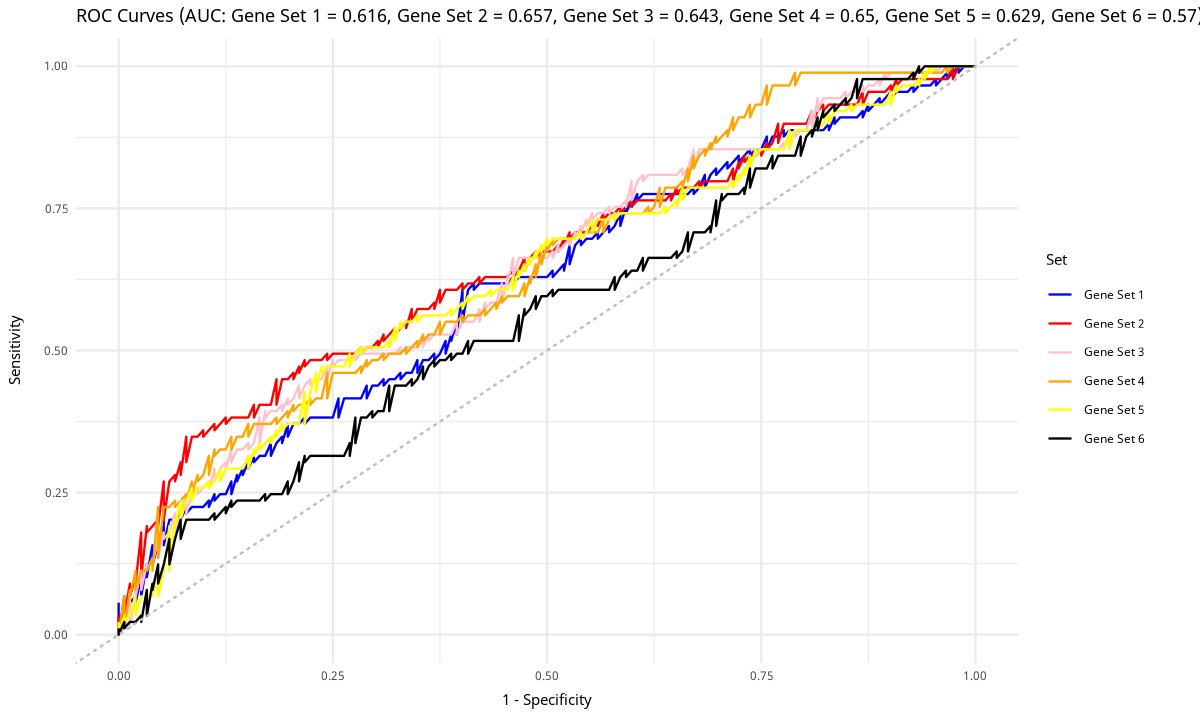

In [93]:
# Plot ROC curves
p1 <- ggplot(roc_data, aes(x = Specificity, y = Sensitivity, color = Set)) +
  geom_line() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  labs(title = paste("ROC Curves (AUC: ", 
                     paste(names(auc_values), "=", round(unlist(auc_values), 3), collapse = ", "), ")", sep = ""),
       x = "1 - Specificity", y = "Sensitivity") +
  scale_color_manual(values = c("Gene Set 1" = "blue", "Gene Set 2" = "red", 
                                "Gene Set 3" = "pink", "Gene Set 4" = "orange", 
                                "Gene Set 5" = "yellow", "Gene Set 6" = "black")) +
  theme_minimal() +
  theme(text = element_text(family = "Noto Sans"))

p1

### Model with glm

In [94]:
# Load data
real_gvc_list_small <- intersect(xQTL_list$gene_id, real_gvc_list$gene_id)
xQTL_list %>% filter(n_methods > 1) %>% pull(gene_id) %>% unique %>% length

set.seed(123456)
# Calculate number of methods for each gene
xQTL_list <- xQTL_list %>%
  mutate(n_methods = str_count(resource_in_FunGen_xQTL, ",") + 1)

# Create filtered lists based on number of methods
xQTL_list_shared <- lapply(2:5, function(n) {
  xQTL_list %>% dplyr::filter(n_methods >= n)
})
names(xQTL_list_shared) <- paste0("shared_", 2:5)

# Function to get transposed expression matrix filtered by gene list
get_exp_matrix <- function(exp, gene_ids) {
  tmp <- exp_raw %>% dplyr::filter(gene_id %in% gene_ids)
  rownames(tmp) <- tmp$gene_id
  t(tmp %>% dplyr::select(any_of(exp_meta$specimenID)))
}

# Prepare expression matrices
gvc_small <- get_exp_matrix(gvc_exp, real_gvc_list_small)
xQTL_exp_all <- get_exp_matrix(exp_raw, xQTL_list$gene_id)
xQTL_exp_shared2 <- get_exp_matrix(exp_raw, xQTL_list_shared$shared_2$gene_id)
xQTL_exp_shared3 <- get_exp_matrix(exp_raw, xQTL_list_shared$shared_3$gene_id)
xQTL_exp_shared4 <- get_exp_matrix(exp_raw, xQTL_list_shared$shared_4$gene_id)
xQTL_exp_shared5 <- get_exp_matrix(exp_raw, xQTL_list_shared$shared_5$gene_id)

# Prepare labels
labels <- exp_meta %>% mutate(labels = ifelse(group == "ad", 1, 0)) %>% pull(labels)

# Create data frames with expression and labels
datasets <- list(
  data1 = data.frame(gvc_exp, Disease = factor(labels)),
  data2 = data.frame(xQTL_exp_all, Disease = factor(labels)),
  data3 = data.frame(xQTL_exp_shared2, Disease = factor(labels)),
  data4 = data.frame(xQTL_exp_shared3, Disease = factor(labels)),
  data5 = data.frame(xQTL_exp_shared4, Disease = factor(labels)),
  data6 = data.frame(xQTL_exp_shared5, Disease = factor(labels)),
  data7 = data.frame(gvc_small, Disease = factor(labels))
)

[1] 59

In [95]:
# Split train/test indices
trainIndex <- createDataPartition(labels, p = 0.7, list = FALSE)

# Split datasets into train/test
train_test <- lapply(datasets, function(df) {
  list(train = df[trainIndex, ], test = df[-trainIndex, ])
})

In [96]:
# Fit logistic regression models
models <- lapply(train_test, function(data) {
  glm(Disease ~ ., data = data$train, family = binomial)
})

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [97]:
# Predict probabilities on test sets
predictions <- mapply(function(model, data) {
  predict(model, data$test, type = "response")
}, models, train_test, SIMPLIFY = FALSE)


In [98]:
# Calculate ROC and AUC
rocs <- mapply(function(pred, data) {
  roc(data$test$Disease, pred)
}, predictions, train_test, SIMPLIFY = FALSE)

aucs <- sapply(rocs, auc)

# Prepare ROC data for plotting
glm_roc_data <- do.call(rbind, lapply(seq_along(rocs), function(i) {
  data.frame(
    Specificity = 1 - rocs[[i]]$specificities,
    Sensitivity = rocs[[i]]$sensitivities,
    Set = paste0("Gene Set ", i)
  )
}))

glm_roc_data <- glm_roc_data %>%
  mutate(Set = case_when(
    Set == "Gene Set 1" ~ "GVC",
    Set == "Gene Set 2" ~ "all xQTL genes",
    Set == "Gene Set 3" ~ "xQTL genes with 2 methods",
    Set == "Gene Set 4" ~ "xQTL genes with 3 methods",
    Set == "Gene Set 5" ~ "xQTL genes with 4 methods",
    Set == "Gene Set 6" ~ "xQTL genes with 5 methods",
    Set == "Gene Set 7" ~ "GVC small",
    TRUE ~ Set
  ))


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



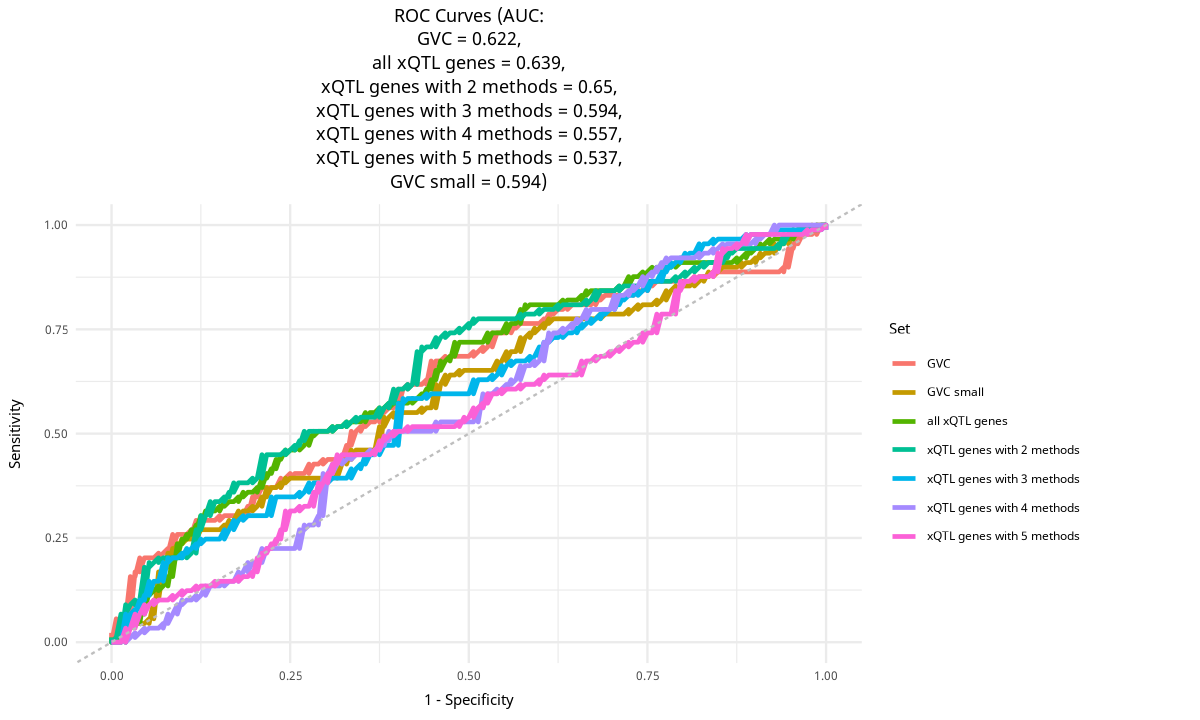

In [99]:
p2 <- ggplot(glm_roc_data, aes(x = Specificity, y = Sensitivity, color = Set)) +
  geom_line(size = 1) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  labs(
    title = paste0(
      "ROC Curves (AUC: \n",
      paste0(c("GVC", "all xQTL genes", "xQTL genes with 2 methods",
               "xQTL genes with 3 methods", "xQTL genes with 4 methods",
               "xQTL genes with 5 methods", "GVC small"),
             " = ", round(aucs, 3), collapse = ", \n"),
      ")"
    ),
    x = "1 - Specificity",
    y = "Sensitivity"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5),
        text = element_text(family = "Noto Sans"))
p2

### GRN

In [100]:
# Load data
reg_net_files <- list.files('/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_S5', pattern = 'txt$', full.names = T)

xqtl_roles_df <- data.frame()
xqtl_genes <- xQTL_list$gene_name

for(i in 1:length(reg_net_files)){
    reg_net <- read_tsv(reg_net_files[i], show_col_types = FALSE )
    suppressWarnings({
      g <- graph_from_data_frame(reg_net, directed = TRUE)    #remove if does not want to suppress warnings
    })
    xqtl_roles <- data.frame(
      gene = xqtl_genes,
      is_in_graph = xqtl_genes %in% V(g)$name,
      out_degree = sapply(xqtl_genes, function(gene) if (gene %in% V(g)$name) degree(g, v = gene, mode = "out") else NA),
      in_degree = sapply(xqtl_genes, function(gene) if (gene %in% V(g)$name) degree(g, v = gene, mode = "in") else NA)
    )
    
    xqtl_roles <- xqtl_roles %>%
      mutate(
        role = case_when(
          is.na(in_degree) ~ "not_in_network",
          out_degree > 0 & in_degree == 0 ~ "regulator",
          in_degree > 0 & out_degree == 0 ~ "target",
          out_degree > 0 & in_degree > 0 ~ "intermediary",
          TRUE ~ "unclassified"),
        file = basename(reg_net_files[i] %>% gsub('.txt','',.))
        
      )
    xqtl_roles_df <- rbind(xqtl_roles_df, xqtl_roles)
}

xqtl_roles_df %>% head

,gene,is_in_graph,out_degree,in_degree,role,file
,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<chr>
SNX11,SNX11,FALSE,NA,NA,not_in_network,Ast_GRN
DHX33,DHX33,FALSE,NA,NA,not_in_network,Ast_GRN
AGK,AGK,FALSE,NA,NA,not_in_network,Ast_GRN
SPAG9,SPAG9,FALSE,NA,NA,not_in_network,Ast_GRN
POLR3B,POLR3B,FALSE,NA,NA,not_in_network,Ast_GRN
RABEP1,RABEP1,FALSE,NA,NA,not_in_network,Ast_GRN


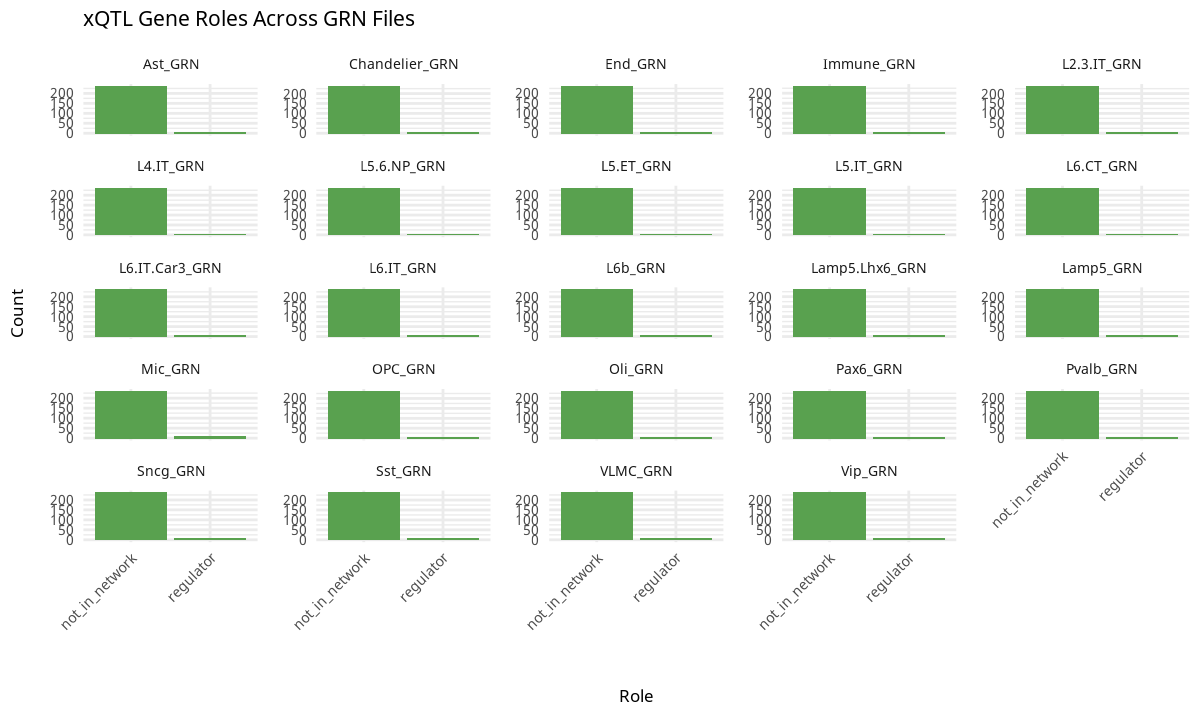

In [101]:
p3 <- ggplot(xqtl_roles_df, aes(x = role)) +
  geom_bar(fill = "#59A14F") +
  facet_wrap(~ file, scales = "free_y") +
  labs(title = "xQTL Gene Roles Across GRN Files", x = "Role", y = "Count") +
  theme_minimal(base_size = 13) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
       text = element_text(family = "Noto Sans"))

p3

### Fisher test between xQTL and xQTL only genes

In [102]:
# Function to process one GRN file
process_grn <- function(grn_file) {
  grn <- read_tsv(grn_file, show_col_types = FALSE)
  if (!all(c("TF", "TG") %in% names(grn))) return(NULL)
  
  reg_net <- grn %>% dplyr::select(source = TF, target = TG) %>% distinct()
  g <- graph_from_data_frame(reg_net, directed = TRUE)
  all_genes <- V(g)$name
  
  get_role <- function(gene) {
    if (!(gene %in% V(g)$name)) return("not_in_network")
    in_deg <- degree(g, gene, mode = "in")
    out_deg <- degree(g, gene, mode = "out")
    if (out_deg > 0 & in_deg == 0) return("regulator")
    else if (in_deg > 0 & out_deg == 0) return("target")
    else if (in_deg > 0 & out_deg > 0) return("intermediary")
    else return("unclassified")
  }
  
  role_df <- data.frame(
    gene = all_genes,
    role = sapply(all_genes, get_role),
    group = ifelse(all_genes %in% xQTL_list$gene_name, "xQTL_only", "background"),
    file = basename(grn_file),
    stringsAsFactors = FALSE
  )
  
  return(role_df)
}

# Function to run Fisher test per file (regulator vs others)
run_fisher_per_file <- function(df, set_role) {
  reg_table <- df %>%
    filter(role %in% c("regulator", "target", "intermediary")) %>%
    mutate(role_bin = ifelse(role == set_role, set_role, "other")) %>%
    count(group, role_bin) %>%
    pivot_wider(names_from = role_bin, values_from = n, values_fill = 0)

  # Check that we have exactly two groups and both role types
  required_cols <- c(set_role, "other")
  if (nrow(reg_table) != 2 || !all(required_cols %in% names(reg_table))) {
    return(NA_real_)
  }

  # Safely extract the contingency table
  mat <- matrix(c(
    reg_table[[set_role]][1], reg_table$other[1],
    reg_table[[set_role]][2], reg_table$other[2]
  ), nrow = 2, byrow = TRUE)

  # Ensure matrix is valid for Fisher test
  if (any(dim(mat) != 2) || any(rowSums(mat) == 0) || any(colSums(mat) == 0)) {
    return(NA_real_)
  }

  fisher.test(mat)$p.value
}

In [103]:
# Process all GRNs and combine
all_roles <- map_dfr(reg_net_files, process_grn)
all_roles_filtered <- all_roles %>% dplyr::filter(role != "not_in_network")

count_table <- all_roles_filtered %>%
  count(file, group, role) %>%
  pivot_wider(names_from = role, values_from = n, values_fill = 0)

print(count_table)

# A tibble: 48 × 5
   file               group      intermediary regulator target
   <chr>              <chr>             <int>     <int>  <int>
 1 Ast_GRN.txt        background          257       127   7899
 2 Ast_GRN.txt        xQTL_only             4         1    127
 3 Chandelier_GRN.txt background          230       178   7441
 4 Chandelier_GRN.txt xQTL_only             3         1    128
 5 End_GRN.txt        background          239       114   7367
 6 End_GRN.txt        xQTL_only             4         1    117
 7 Immune_GRN.txt     background          242        98   7979
 8 Immune_GRN.txt     xQTL_only             6         0    152
 9 L2.3.IT_GRN.txt    background          279       107   9862
10 L2.3.IT_GRN.txt    xQTL_only             4         0    146
# ℹ 38 more rows


In [104]:
# Calculate Fisher p-values per file
fisher_results <- all_roles_filtered %>%
  group_by(file) %>%
  group_split() %>%
  map_dbl(~run_fisher_per_file(.x, set_role = 'regulator'))

fisher_summary <- tibble(
  file = unique(all_roles_filtered$file),
  fisher_p_value = fisher_results
)

print(fisher_summary %>% arrange(fisher_p_value))

# A tibble: 24 × 2
   file               fisher_p_value
   <chr>                       <dbl>
 1 Immune_GRN.txt              0.267
 2 Mic_GRN.txt                 0.267
 3 Oli_GRN.txt                 0.267
 4 Sncg_GRN.txt                0.373
 5 Vip_GRN.txt                 0.373
 6 Chandelier_GRN.txt          0.374
 7 Lamp5_GRN.txt               0.375
 8 L6.IT.Car3_GRN.txt          0.408
 9 L5.IT_GRN.txt               0.409
10 L6b_GRN.txt                 0.409
# ℹ 14 more rows


In [105]:
# Calculate Fisher p-values per file
fisher_results <- all_roles_filtered %>%
  group_by(file) %>%
  group_split() %>%
  map_dbl(~run_fisher_per_file(.x, set_role = 'target'))

fisher_summary <- tibble(
  file = unique(all_roles_filtered$file),
  fisher_p_value = fisher_results
)

print(fisher_summary %>% arrange(fisher_p_value))

# A tibble: 24 × 2
   file               fisher_p_value
   <chr>                       <dbl>
 1 Chandelier_GRN.txt          0.325
 2 Pvalb_GRN.txt               0.325
 3 Sst_GRN.txt                 0.421
 4 OPC_GRN.txt                 0.530
 5 Lamp5_GRN.txt               0.558
 6 L5.IT_GRN.txt               0.663
 7 L4.IT_GRN.txt               0.663
 8 L6.CT_GRN.txt               0.664
 9 L5.6.NP_GRN.txt             0.664
10 L6.IT.Car3_GRN.txt          0.664
# ℹ 14 more rows


In [106]:
# Calculate Fisher p-values per file
fisher_results <- all_roles_filtered %>%
  group_by(file) %>%
  group_split() %>%
  map_dbl(~run_fisher_per_file(.x, set_role = 'intermediary'))

fisher_summary <- tibble(
  file = unique(all_roles_filtered$file),
  fisher_p_value = fisher_results
)

print(fisher_summary %>% arrange(fisher_p_value))

# A tibble: 24 × 2
   file            fisher_p_value
   <chr>                    <dbl>
 1 Mic_GRN.txt              0.465
 2 Immune_GRN.txt           0.470
 3 Pvalb_GRN.txt            0.596
 4 Sncg_GRN.txt             0.788
 5 End_GRN.txt              0.792
 6 Vip_GRN.txt              0.792
 7 Pax6_GRN.txt             0.793
 8 L5.6.NP_GRN.txt          0.799
 9 Lamp5_GRN.txt            0.799
10 Sst_GRN.txt              0.800
# ℹ 14 more rows


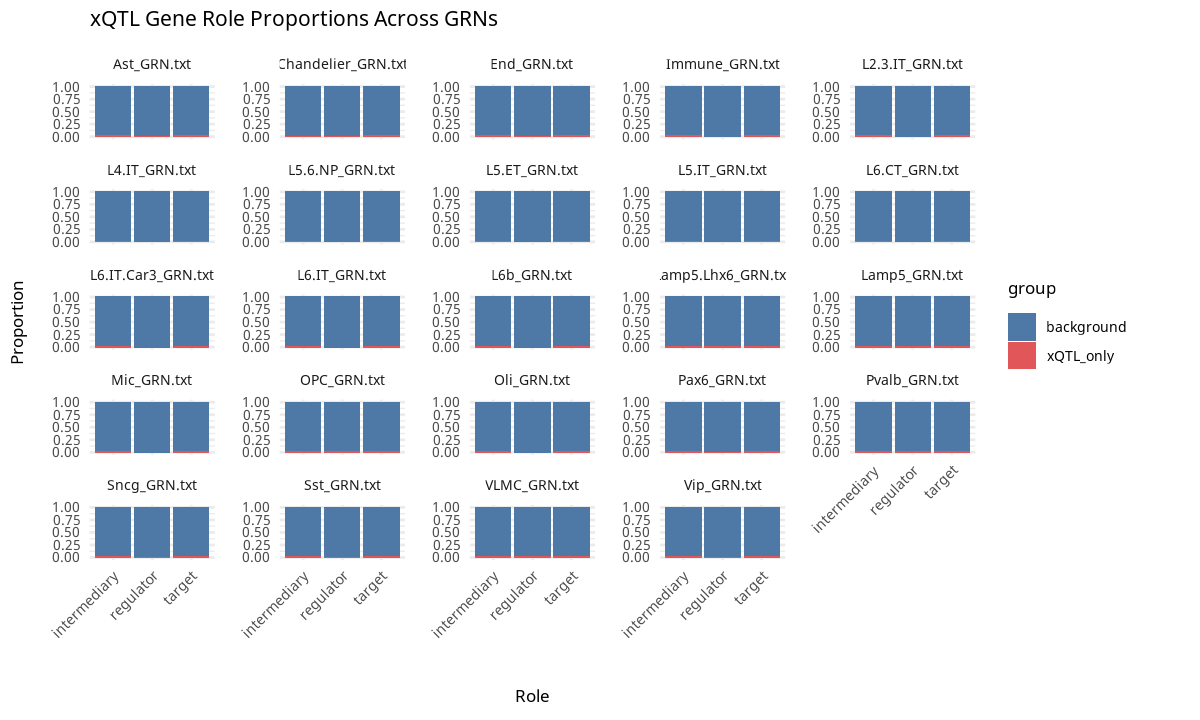

In [107]:
# Visualization: Role distribution per GRN file by group
p4 <- ggplot(all_roles_filtered, aes(x = role, fill = group)) +
  geom_bar(position = "fill") +
  facet_wrap(~ file, scales = "free_y") +
  labs(title = "xQTL Gene Role Proportions Across GRNs",
       x = "Role", y = "Proportion") +
  scale_fill_manual(values = c("xQTL_only" = "#E15759", "background" = "#4E79A7")) +
  theme_minimal(base_size = 13) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),text = element_text(family = "Noto Sans"))


p4

In [108]:
all_roles_filtered %>% head

,gene,role,group,file
,<chr>,<chr>,<chr>,<chr>
RXRG...1,RXRG,intermediary,background,Ast_GRN.txt
NR2F1...2,NR2F1,intermediary,background,Ast_GRN.txt
IRF1...3,IRF1,intermediary,background,Ast_GRN.txt
ESR1...4,ESR1,intermediary,background,Ast_GRN.txt
ZNF143...5,ZNF143,intermediary,background,Ast_GRN.txt
CREB3L1...6,CREB3L1,intermediary,background,Ast_GRN.txt


In [109]:
df <- data.frame()
for(i in reg_net_files){
    df <- rbind(df, fread(i) %>% mutate(file = basename(i)))
}
df %>% head

TF,enhancer,promoter,TG,edgeWeight,method,celltype,Correlation,Regulation,file
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
RXRG,chr1:1019276-1019776,chr1:958584-960584,KLHL17,0.12987922,scGRNom,Ast,0.6773105,Activating,Ast_GRN.txt
NR2F1,chr1:1019276-1019776,chr1:958584-960584,KLHL17,0.06547182,scGRNom,Ast,-0.1551904,Repressing,Ast_GRN.txt
IRF1,chr1:1019276-1019776,chr1:958584-960584,KLHL17,0.06022639,scGRNom,Ast,0.6686182,Activating,Ast_GRN.txt
ESR1,chr1:1019276-1019776,chr1:958584-960584,KLHL17,0.06465946,scGRNom,Ast,0.5641387,Activating,Ast_GRN.txt
ZNF143,chr1:1019276-1019776,chr1:958584-960584,KLHL17,0.04856990,scGRNom,Ast,0.3650754,Activating,Ast_GRN.txt
CREB3L1,chr1:1019276-1019776,chr1:958584-960584,KLHL17,0.09256433,scGRNom,Ast,0.7666757,Activating,Ast_GRN.txt


### Target network

NULL

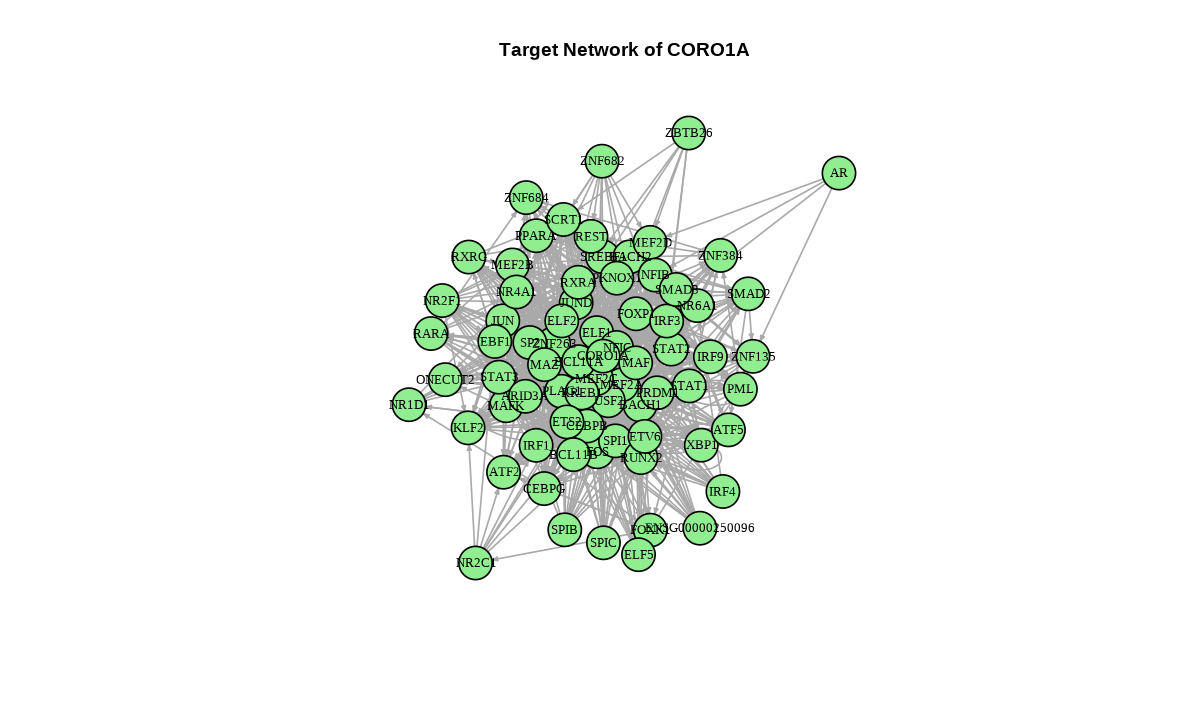

In [110]:
# grn <- read_tsv(reg_net_files[5], show_col_types = FALSE)
df <- readRDS('/restricted/projectnb/xqtl/jaempawi/xqtl/all_GRN.rds')
reg_net <- df %>% dplyr::select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

focus_gene <- "CORO1A" 
neighbors_g <- ego(g, order = 1, nodes = focus_gene, mode = "in")[[1]]
subg <- induced_subgraph(g, neighbors_g)

p5 <- plot(subg,
     vertex.label.cex = 0.8,
     vertex.label.color = "black",
     vertex.color = "lightgreen",
     edge.arrow.size = 0.3,
     layout = layout_with_fr,
     main = paste("Target Network of", focus_gene))
p5
coro1a_genes <- names(neighbors_g)

NULL

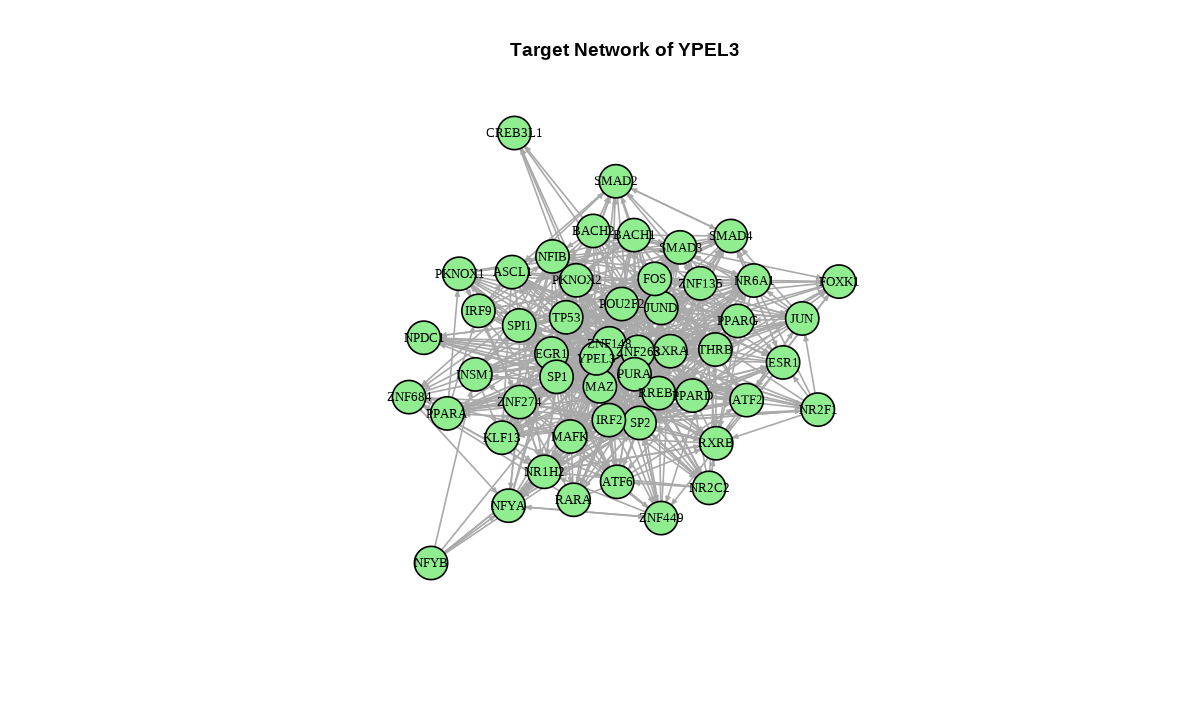

In [111]:
# grn <- read_tsv(reg_net_files[5], show_col_types = FALSE)
reg_net <- df %>% dplyr::select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

focus_gene <- "YPEL3" 
neighbors_g <- ego(g, order = 1, nodes = focus_gene, mode = "in")[[1]]
subg2 <- induced_subgraph(g, neighbors_g)

p6 <- plot(subg2,
     vertex.label.cex = 0.8,
     vertex.label.color = "black",
     vertex.color = "lightgreen",
     edge.arrow.size = 0.3,
     layout = layout_with_fr,
     main = paste("Target Network of", focus_gene))
p6
ypel3_genes <- names(neighbors_g)

NULL

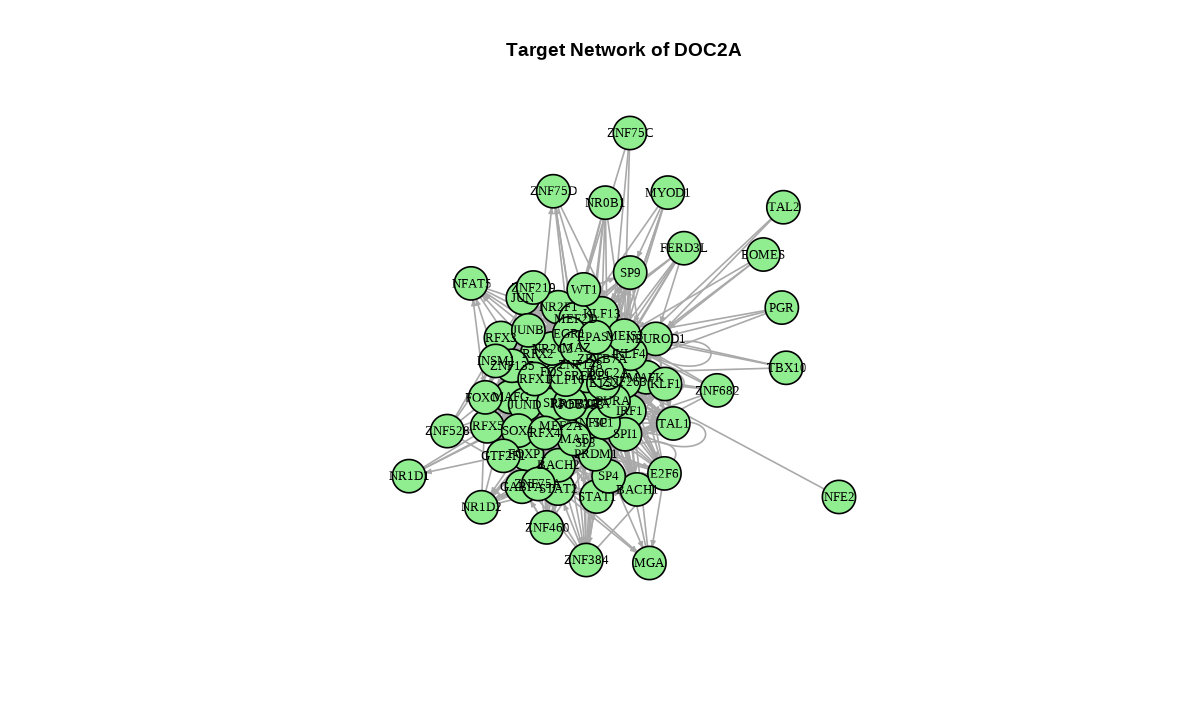

In [112]:
# grn <- read_tsv(reg_net_files[5], show_col_types = FALSE)

reg_net <- df %>% dplyr::select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

focus_gene <- "DOC2A" 
neighbors_g <- ego(g, order = 1, nodes = focus_gene, mode = "in")[[1]]
subg3 <- induced_subgraph(g, neighbors_g)

p7 <- plot(subg3,
     vertex.label.cex = 0.8,
     vertex.label.color = "black",
     vertex.color = "lightgreen",
     edge.arrow.size = 0.3,
     layout = layout_with_fr,
     main = paste("Target Network of", focus_gene))

p7
doc2a_genes <- names(neighbors_g)

NULL

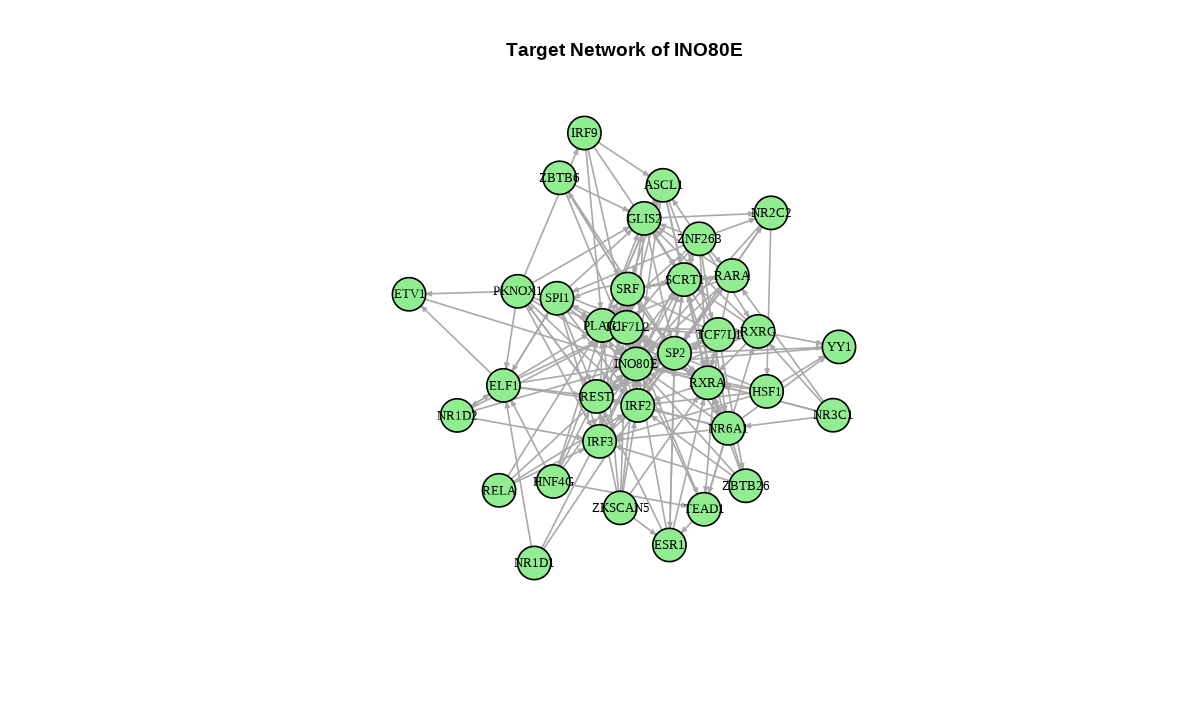

In [113]:
# grn <- read_tsv(reg_net_files[5], show_col_types = FALSE)

reg_net <- df %>% dplyr::select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

focus_gene <- "INO80E" 
neighbors_g <- ego(g, order = 1, nodes = focus_gene, mode = "in")[[1]]
subg4 <- induced_subgraph(g, neighbors_g)

p8 <- plot(subg4,
     vertex.label.cex = 0.8,
     vertex.label.color = "black",
     vertex.color = "lightgreen",
     edge.arrow.size = 0.3,
     layout = layout_with_fr,
     main = paste("Target Network of", focus_gene))
p8
ino80e_genes <- names(neighbors_g)

In [114]:
multi_gene_list <- c('YPEL3', 'INO80E', 'DOC2A', 'MAPK3', 'CORO1A', 'BCKDK', 'TLCD3B', 'ZNF267', 'AC093512.2', 'PRSS8', 'TAOK2', 'TMEM219')
multi_gene_list %>% length

multi_gene_list_name <- multi_gene_list
valid_genes <- multi_gene_list_name[multi_gene_list_name %in% V(g)$name]
valid_genes %>% length
V(g)$name %>% length


[1] 12

[1] 9

[1] 14484

In [115]:
tf_genes <- list()
for (gene in valid_genes) {
  neighbors_g <- ego(g, order = 1, nodes = gene, mode = "in")[[1]]
  tf_genes[[gene]] <- setdiff(names(neighbors_g), gene)
}

tf_genes

$YPEL3
 [1] "NR2F1"   "ESR1"    "CREB3L1" "JUN"     "ATF2"    "JUND"    "BACH1"  
 [8] "RXRA"    "THRB"    "ZNF148"  "MAFK"    "TP53"    "PPARD"   "FOXK1"  
[15] "ZNF263"  "NFYB"    "SP2"     "FOS"     "RARA"    "BACH2"   "RREB1"  
[22] "IRF2"    "SPI1"    "NR2C2"   "KLF13"   "NR1H2"   "RXRB"    "ZNF135" 
[29] "PPARA"   "EGR1"    "NFIB"    "PKNOX2"  "NR6A1"   "PKNOX1"  "ASCL1"  
[36] "PPARG"   "SMAD3"   "ZNF684"  "NFYA"    "SMAD2"   "SMAD4"   "SP1"    
[43] "MAZ"     "IRF9"    "POU2F2"  "ZNF274"  "ATF6"    "ZNF449"  "INSM1"  
[50] "PURA"    "NPDC1"  

$INO80E
 [1] "RXRG"    "ESR1"    "ELF1"    "RXRA"    "TEAD1"   "PLAG1"   "ZBTB26" 
 [8] "ZNF263"  "TCF7L1"  "ZBTB6"   "TCF7L2"  "SP2"     "NR1D1"   "RARA"   
[15] "HNF4G"   "NR1D2"   "IRF3"    "IRF2"    "SPI1"    "NR2C2"   "NR3C1"  
[22] "REST"    "YY1"     "NR6A1"   "PKNOX1"  "ASCL1"   "ZKSCAN5" "HSF1"   
[29] "IRF9"    "SCRT1"   "ETV1"    "SRF"     "GLIS2"   "RELA"   

$DOC2A
 [1] "NR2F1"   "IRF1"    "ZBTB7A"  "ZNF528"  "JUN"     "SP3"     "MAFG"   
 [8] "JUND"    "BACH1"   "STAT1"   "FOXP1"   "RXRA"    "MEF2A"   "RFX5"   
[15] "POU3F3"  "ZNF148"  "RFX3"    "STAT2"   "NFIC"    "MAFK"    "SP4"    
[22] "ZNF460"  "SOX4"    "ZNF384"  "E2F6"    "ZNF263"  "SP2"     "ZNF682" 
[29] "FOS"     "PRDM1"   "SREBF1"  "NR1D1"   "RFX2"    "NR1D2"   "BACH2"  
[36] "RREB1"   "SPI1"    "NR2C2"   "KLF13"   "MEF2D"   "ZNF135"  "EGR1"   
[43] "MAF"     "GABPA"   "SP1"     "MAZ"     "JUNB"    "RFX4"    "KLF16"  
[50] "RFX1"    "NEUROD1" "SP9"     "ZNF75D"  "INSM1"   "FOXO1"   "MGA"    
[57] "ZNF75A"  "WT1"     "PURA"    "NR0B1"   "KLF4"    "MEIS3"   "MYOD1"  
[64] "FERD3L"  "TAL1"    "TAL2"    "NFE2"    "ZNF219"  "KLF1"    "GTF2F1" 
[71] "ETS2"    "EPAS1"   "EOMES"   "PGR"     "NFAT5"   "TBX10"   "ZNF75C" 

$MAPK3
 [1] "RXRG"    "NR2F1"   "IRF1"    "KLF15"   "JUN"     "MAFG"    "CEBPG"  
 [8] "ATF4"    "STAT1"   "FOXP1"   "RXRA"    "MEF2A"   "USF2"    "THRB"   
[15] "PBX3"    "NFIC"    "SP4"     "ZNF460"  "ZNF384"  "E2F6"    "ZNF263" 
[22] "SP2"     "MEF2C"   "PRDM1"   "RARG"    "RARA"    "IRF3"    "SPI1"   
[29] "KLF13"   "MEF2D"   "RXRB"    "EGR1"    "NR3C1"   "NFIB"    "PKNOX2" 
[36] "SMAD3"   "SMAD2"   "CEBPA"   "ZNF382"  "SP1"     "MAZ"     "RARB"   
[43] "MITF"    "BHLHE41" "USF1"    "CEBPD"   "ELF2"    "RELA"    "ETV6"   
[50] "ZNF76"   "RUNX1"   "ETS2"    "ELF5"    "SPIB"    "ZNF683"  "ATF5"   
[57] "SPIC"   

$CORO1A
 [1] "RXRG"            "NR2F1"           "IRF1"            "ELF1"           
 [5] "ONECUT2"         "JUN"             "ATF2"            "JUND"           
 [9] "CEBPG"           "BACH1"           "STAT1"           "FOXP1"          
[13] "RXRA"            "MEF2A"           "USF2"            "STAT2"          
[17] "NFIC"            "EBF1"            "MAFK"            "PLAG1"          
[21] "MEF2B"           "FOXK1"           "ZBTB26"          "ZNF384"         
[25] "ZNF263"          "SP2"             "ZNF682"          "XBP1"           
[29] "FOS"             "MEF2C"           "PRDM1"           "SREBF1"         
[33] "NR1D1"           "RARA"            "BACH2"           "IRF3"           
[37] "RREB1"           "SPI1"            "MEF2D"           "ZNF135"         
[41] "PPARA"           "NFIB"            "REST"            "AR"             
[45] "NR6A1"           "MAF"             "PKNOX1"          "SMAD3"          
[49] "ZNF684"          "RUNX2"           "SMAD2"           "MAZ"            
[53] "IRF9"            "SCRT1"           "NR4A1"           "ELF2"           
[57] "STAT3"           "ETV6"            "CEBPB"           "PML"            
[61] "BCL11A"          "NR2C1"           "ETS2"            "KLF2"           
[65] "ELF5"            "ARID3A"          "SPIB"            "BCL11B"         
[69] "ENSG00000250096" "IRF4"            "ATF5"            "SPIC"           

$BCKDK
[1] "ZNF148" "MAZ"    "PURA"  

$ZNF267
 [1] "IRF1"   "ESR1"   "STAT1"  "MZF1"   "SP4"    "SP2"    "PRDM1"  "RREB1" 
 [9] "IRF2"   "NFIB"   "YY1"    "SMAD2"  "IKZF1"  "ZNF75D" "PML"    "ETV3"  
[17] "REL"   

$

In [116]:
tf_genes$INO80E %>% .[ . %in% multi_gene_list]
tf_genes$DOC2A %>% .[. %in% multi_gene_list]
tf_genes$MAPK3 %>% .[. %in% multi_gene_list]
tf_genes$CORO1A %>% .[. %in% multi_gene_list]

character(0)

character(0)

character(0)

character(0)

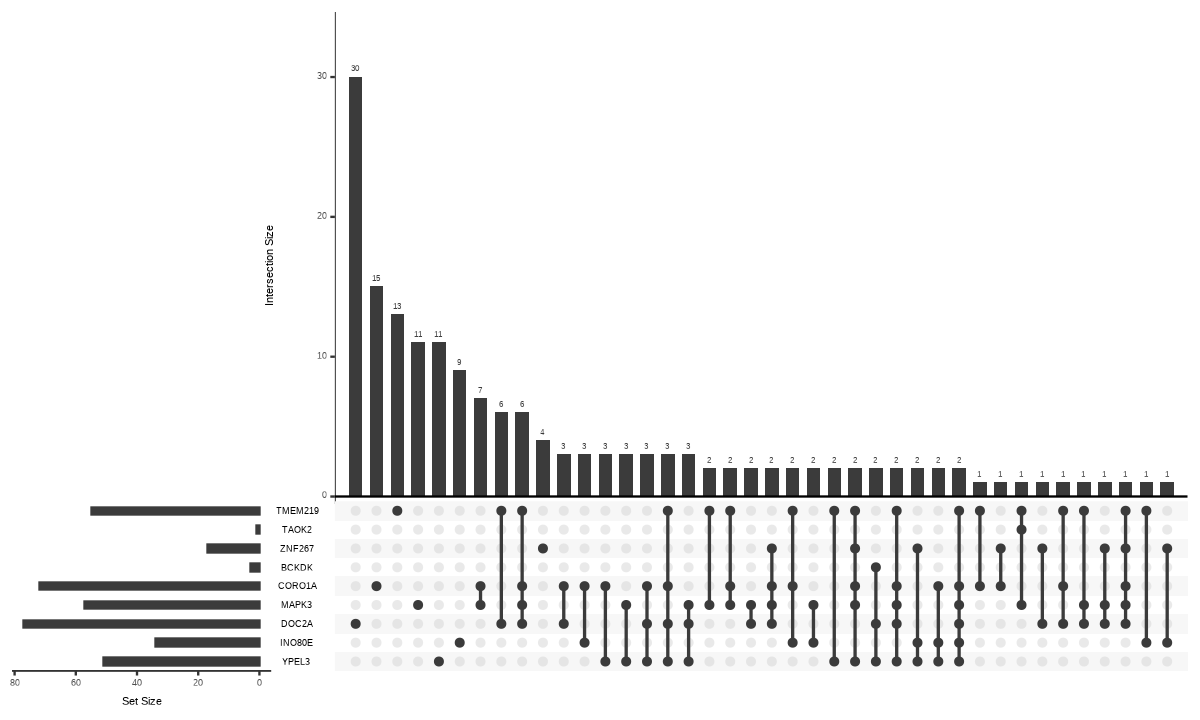

In [117]:
# Convert list to binary presence/absence data frame
gene_matrix <- fromList(tf_genes)

# Create the UpSet plot
p9 <- upset(gene_matrix, sets = names(tf_genes), keep.order = TRUE, order.by = "freq")
p9

In [118]:
tf_genes %>% str

List of 9
 $ YPEL3  : chr [1:51] "NR2F1" "ESR1" "CREB3L1" "JUN" ...
 $ INO80E : chr [1:34] "RXRG" "ESR1" "ELF1" "RXRA" ...
 $ DOC2A  : chr [1:77] "NR2F1" "IRF1" "ZBTB7A" "ZNF528" ...
 $ MAPK3  : chr [1:57] "RXRG" "NR2F1" "IRF1" "KLF15" ...
 $ CORO1A : chr [1:72] "RXRG" "NR2F1" "IRF1" "ELF1" ...
 $ BCKDK  : chr [1:3] "ZNF148" "MAZ" "PURA"
 $ ZNF267 : chr [1:17] "IRF1" "ESR1" "STAT1" "MZF1" ...
 $ TAOK2  : chr "ATF4"
 $ TMEM219: chr [1:55] "NR2F1" "ELF1" "ONECUT2" "JUN" ...


[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"


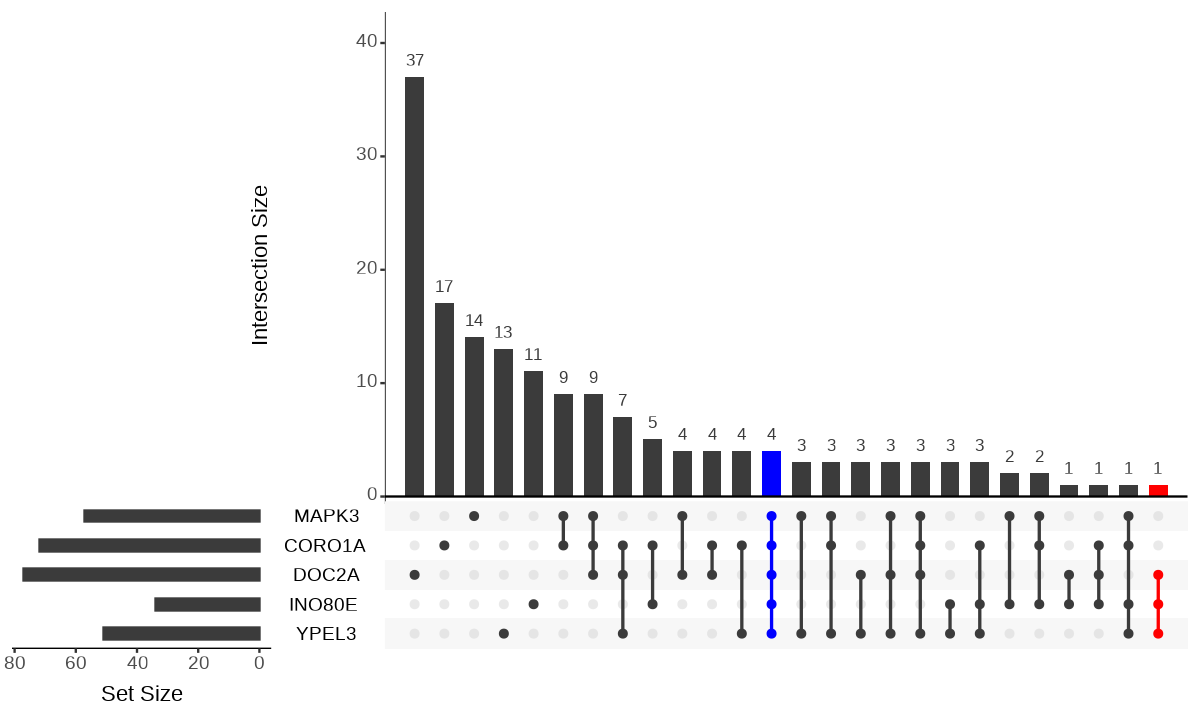

In [119]:
# Build the binary matrix from tf_genes
all_tfs <- unique(unlist(tf_genes))
tf_gene_matrix <- as.data.frame(
  sapply(tf_genes, function(gene_tfs) as.integer(all_tfs %in% gene_tfs))
)
rownames(tf_gene_matrix) <- all_tfs

# Check column names
print(colnames(tf_gene_matrix))  # Should include "YPEL3", "INO80E", "DOC2A"
options(repr.plot.width = 10, repr.plot.height = 6)

# Generate the UpSet plot with highlighted intersections
p10 <- upset(
  tf_gene_matrix,
  sets = c("YPEL3", "INO80E", "DOC2A", "CORO1A", "MAPK3"),
  keep.order = TRUE,
  order.by = "freq",
  queries = list(
    list(
      query = intersects,
      params = list("YPEL3", "INO80E", "DOC2A"),
      color = "red",
      active = TRUE,
      query.name = "Shared: YPEL3+INO80E+DOC2A"
    ),
    list(
      query = intersects,
      params = list("YPEL3", "INO80E", "DOC2A", "CORO1A", "MAPK3"),
      color = "blue",
      active = TRUE,
      query.name = "Shared: All Five Genes"
    )
  ),
  text.scale = 2
)

p10

In [120]:
# Filter rows where all three genes are present (shared)
rownames(gene_matrix) <- unique(unlist(tf_genes))
shared_rows <- gene_matrix %>%
  filter(YPEL3 == 1, INO80E == 1, DOC2A == 1)
shared_rows

,YPEL3,INO80E,DOC2A,MAPK3,CORO1A,BCKDK,ZNF267,TAOK2,TMEM219
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
RXRA,1,1,1,1,1,0,0,0,1
ZNF263,1,1,1,1,1,0,0,0,1
SP2,1,1,1,1,1,0,1,0,0
SPI1,1,1,1,1,1,0,0,0,0
NR2C2,1,1,1,0,0,0,0,0,0


In [121]:
names(tf_genes)
Reduce(intersect, tf_genes[-c(9)])
names(tf_genes[-c(9)])

[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"

character(0)

[1] "YPEL3"  "INO80E" "DOC2A"  "MAPK3"  "CORO1A" "BCKDK"  "ZNF267" "TAOK2"

In [122]:
names(tf_genes)
Reduce(intersect, tf_genes[-c(2,8:9)])
names(tf_genes[-c(2,8:9)])

[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"

character(0)

[1] "YPEL3"  "DOC2A"  "MAPK3"  "CORO1A" "BCKDK"  "ZNF267"

In [123]:
names(tf_genes)
Reduce(intersect, tf_genes[-c(2, 7:9)])
names(tf_genes[-c(2, 7:9)])

[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"

[1] "MAZ"

[1] "YPEL3"  "DOC2A"  "MAPK3"  "CORO1A" "BCKDK"

In [124]:
names(tf_genes)
Reduce(intersect, tf_genes[-c(2, 6:9)])
names(tf_genes[-c(2, 6:9)])

[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"

[1] "NR2F1"  "JUN"    "RXRA"   "ZNF263" "SP2"    "SPI1"   "MAZ"

[1] "YPEL3"  "DOC2A"  "MAPK3"  "CORO1A"

In [125]:
names(tf_genes)
Reduce(intersect, tf_genes[-c(1:2, 6:9)])
names(tf_genes[-c(1:2, 6:9)])

[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"

[1] "NR2F1"  "IRF1"   "JUN"    "STAT1"  "FOXP1"  "RXRA"   "MEF2A"  "NFIC"  
 [9] "ZNF384" "ZNF263" "SP2"    "PRDM1"  "SPI1"   "MEF2D"  "MAZ"    "ETS2"

[1] "DOC2A"  "MAPK3"  "CORO1A"

In [126]:
retest_genes <- Reduce(intersect, tf_genes[3:4])
retest_in_tf_genes <- list()
for (gene in retest_genes) {
  neighbors_g <- ego(g, order = 1, nodes = gene, mode = "in")[[1]]
  retest_in_tf_genes[[gene]] <- setdiff(names(neighbors_g), gene)
}
retest_in_tf_genes

$NR2F1
 [1] "KLF15"  "SP3"    "ZNF148" "ZNF263" "SP2"    "MAZ"    "KLF16"  "NR2F2" 
 [9] "WT1"    "PURA"   "MEIS3" 

$IRF1
 [1] "NR2F1"  "ZBTB7A" "KLF15"  "SP3"    "STAT1"  "ZNF148" "EBF1"   "SP4"   
 [9] "E2F6"   "ZNF263" "TCF7L2" "SP2"    "NFIX"   "HNF4G"  "YY1"    "NFKB1" 
[17] "SP1"    "MAZ"    "ZNF740" "FOXP2"  "CEBPD"  "ELF2"   "SP9"    "STAT3" 
[25] "KLF5"   "KLF6"   "NR2F2"  "PLAGL1" "ZFY"    "ZFX"    "TFAP2C" "PATZ1" 
[33] "WT1"    "PURA"   "TFAP2B" "KLF4"   "NR2C1"  "SP8"    "SP7"    "KLF1"  
[41] "SPZ1"   "HCFC1"  "ETS2"   "RELB"   "FOXA2"  "ETV7"   "FOXD3"  "FOXS1" 
[49] "FOXA3" 

$JUN
 [1] "RXRG"    "NR2F1"   "ELF1"    "JUND"    "RXRA"    "EBF1"    "FOS"    
 [8] "NR2F6"   "HNF4G"   "RXRB"    "FOSL2"   "JUNB"    "FOXP2"   "STAT3"  
[15] "BHLHE40" "PATZ1"   "ERG"     "KLF1"    "ETV7"    "HNF4A"   "FOXO4"  
[22] "FOXP3"  

$MAFG
 [1] "NR2F1"   "ESR1"    "ZNF143"  "JUN"     "ATF4"    "RXRA"    "USF2"   
 [8] "BCL6"    "NRF1"    "RFX5"    "ZNF148"  "RFX3"    "EBF1"    "TP53"   
[15] "KLF9"    "SP2"     "TCF4"    "PRDM1"   "HNF4G"   "BACH2"   "EGR3"   
[22] "ZKSCAN5" "SMAD3"   "ZNF136"  "GABPA"   "ZNF684"  "NFYA"    "RUNX2"  
[29] "ZNF410"  "MAZ"     "POU2F2"  "ETV1"    "MEIS2"   "HINFP"   "USF1"   
[36] "MEIS1"   "NR4A2"   "E2F4"    "NFYC"    "PBX2"    "TFEC"    "STAT3"  
[43] "TCF3"    "ZNF341"  "ARNT2"   "FLI1"    "ETV4"    "UBTF"    "PRDM4"  

$STAT1
 [1] "JUND"   "RXRA"   "MEF2A"  "THRB"   "STAT2"  "ZNF384" "XBP1"   "SREBF1"
 [9] "RUNX2"  "IRF9"   "JDP2"   "ATF6"   "THAP11" "STAT3"  "FLI1"   "ETS1"  

$FOXP1
[1] "ELF1"   "HLF"    "FLI1"   "ETS1"   "FOXO1"  "FOXO3"  "ERG"    "CTNNB1"

$RXRA
  [1] "RXRG"            "NR2F1"           "ESR1"            "CREB3L1"        
  [5] "ZBTB7A"          "KLF15"           "SP3"             "NFE2L1"         
  [9] "MAFG"            "BACH1"           "USF2"            "SCRT2"          
 [13] "THRB"            "BCL6"            "POU3F3"          "ZNF148"         
 [17] "NFIC"            "MZF1"            "EBF1"            "PLAG1"          
 [21] "ZNF460"          "PPARD"           "ZBTB26"          "E2F6"           
 [25] "KLF9"            "ZNF263"          "TCF7L1"          "SP2"            
 [29] "XBP1"            "HSF4"            "RFX2"            "NFIX"           
 [33] "RARA"            "RREB1"           "NFE2L2"          "ESR2"           
 [37] "RXRB"            "PPARA"           "EGR1"            "NR3C1"          
 [41] "NR6A1"           "MAF"             "ASCL1"           "ZKSCAN5"        
 [45] "PPARG"           "GABPA"           "SMAD2"           "SMAD4"          
 [49] "NFKB1"           "SP1"             "MAZ"             "HSF1"           
 [53] "CREB3"           "GLIS3"           "HSF2"            "SCRT1"          
 [57] "ZNF740"          "KLF16"           "ATF6"            "ZNF16"          
 [61] "NEUROD1"         "SOX2"            "ZNF449"          "KLF5"           
 [65] "INSM1"           "TCF12"           "SMAD5"           "KLF6"           
 [69] "ZNF281"          "MXD4"            "TFCP2L1"         "PLAGL1"         
 [73] "ZFY"             "MSX2"            "BSX"             "LHX9"           
 [77] "PRRX2"           "SHOX2"           "RAX2"            "ISX"            
 [81] "SHOX"            "ZFX"             "DLX3"            "DLX2"           
 [85] "TFAP2C"          "EN1"             "ENSG00000229544" "GBX1"           
 [89] "RFX7"            "PATZ1"           "HOXA4"           "PRRX1"          
 [93] "WT1"             "PURA"            "ZNF350"          "MECP2"          
 [97] "TFAP2B"          "SMAD1"           "KLF4"            "DLX4"           
[101] "MYOG"            "ASCL2"           "MYF5"            "LMO2"           
[105] "MAFA"            "NHLH2"           "NHLH1"           "LYL1"           
[109] "CTCFL"           "KLF1"            "UBTF"            "SP6"            
[113] "SP5"             "ZIC4"            "TFAP2D"          "PTF1A"          

$MEF2A
  [1] "RXRG"            "IRF1"            "ESR1"            "ZBTB7A"         
  [5] "ZNF528"        

In [127]:
retest_in_tf_genes$RXRA %>% .[. %in% retest_genes]
retest_in_tf_genes$ZNF263 %>% .[ . %in% retest_genes]
retest_in_tf_genes$SP2 %>% .[. %in% retest_genes]
retest_in_tf_genes$SPI1 %>% .[. %in% retest_genes]
retest_in_tf_genes$NR2C2 %>% .[. %in% retest_genes]

[1] "NR2F1"  "MAFG"   "NFIC"   "ZNF460" "E2F6"   "ZNF263" "SP2"    "EGR1"  
 [9] "SP1"    "MAZ"

character(0)

[1] "NR2F1"  "STAT1"  "FOXP1"  "MEF2A"  "SP4"    "ZNF460" "KLF13"  "EGR1"  
 [9] "SP1"    "MAZ"

[1] "IRF1"   "STAT1"  "FOXP1"  "ZNF263" "SP2"    "PRDM1"  "SP1"    "MAZ"   
[9] "ETS2"

NULL

### Key regulatory pathway

NULL

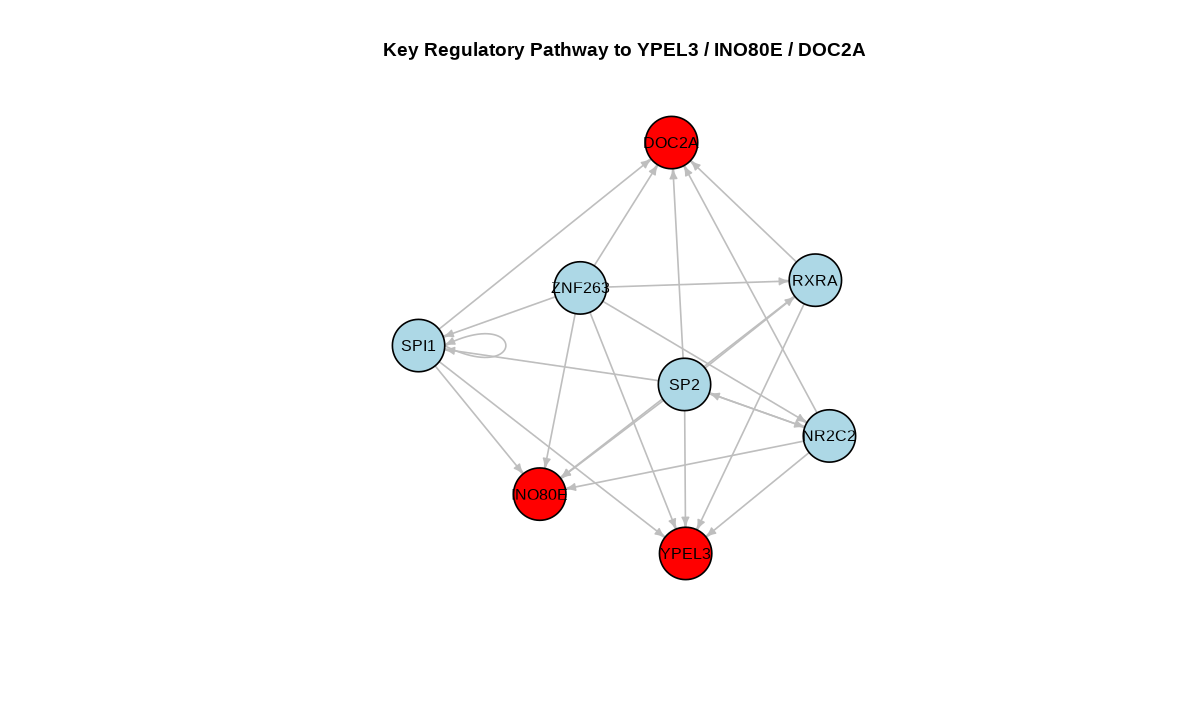

In [128]:
# Define all relevant nodes
focus_gene <- c("YPEL3", "INO80E", "DOC2A")
core_nodes <- c("NR2C2", "ZNF263", "SP2", "SPI1", "RXRA", focus_gene)

reg_net <- unique(df[, .(source = TF, target = TG)])
#reg_net <- df %>% select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)
# Extract subgraph with only those nodes
subg5 <- induced_subgraph(g, vids = V(g)[name %in% core_nodes])

# Set edge colors to highlight direction (optional)
E(subg5)$color <- "gray"
V(subg5)$color <- ifelse(V(subg5)$name %in% focus_gene, "red", "lightblue")

p11 <- plot(subg5,
     vertex.label.cex = 1,
     vertex.label.family = "sans",  # Set label fontplot(subg,
     vertex.label.cex = 1,
     vertex.label.color = "black",
     vertex.color = V(subg5)$color,
     vertex.size = 25,
     edge.arrow.size = 0.5,
     layout = layout_with_fr(subg5),
     main = "Key Regulatory Pathway to YPEL3 / INO80E / DOC2A")
p11

In [129]:
multi_gene_list

[1] "YPEL3"      "INO80E"     "DOC2A"      "MAPK3"      "CORO1A"    
 [6] "BCKDK"      "TLCD3B"     "ZNF267"     "AC093512.2" "PRSS8"     
[11] "TAOK2"      "TMEM219"

NULL

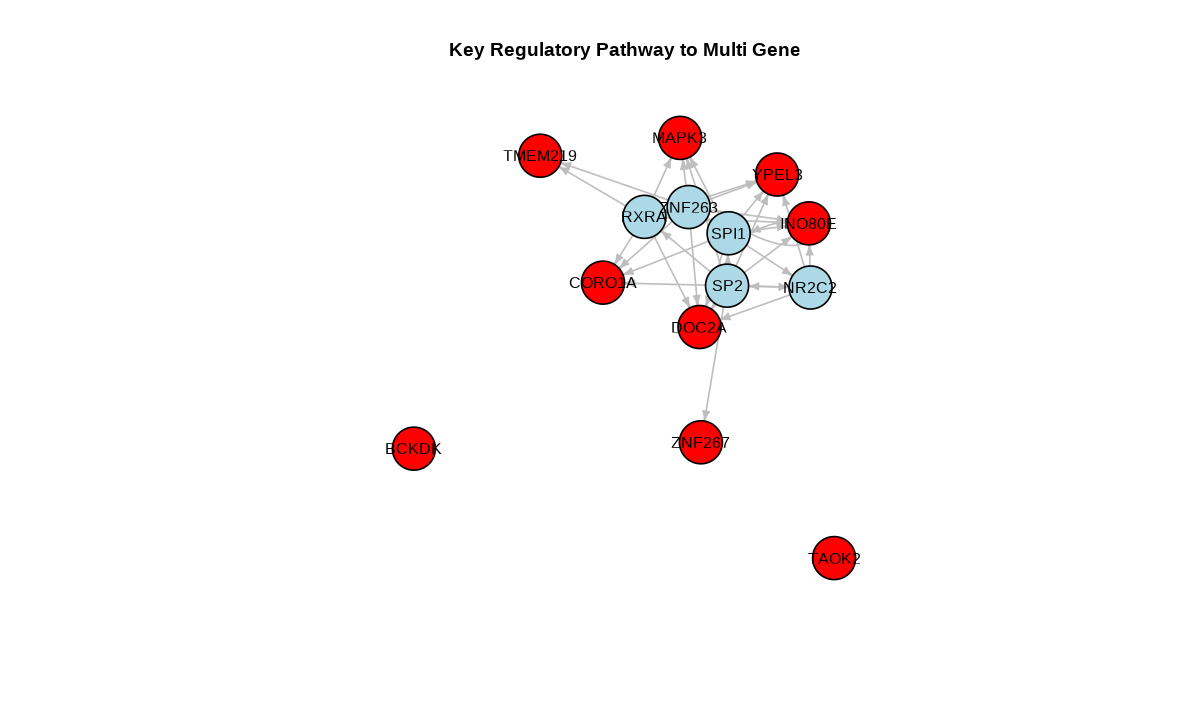

In [130]:
# Define all relevant nodes
focus_gene <- multi_gene_list_name
core_nodes <- c("NR2C2", "ZNF263", "SP2", "SPI1", "RXRA", focus_gene)

reg_net <- df %>% dplyr::select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)
# Extract subgraph with only those nodes
subg6 <- induced_subgraph(g, vids = V(g)[name %in% core_nodes])

# Set edge colors to highlight direction (optional)
E(subg6)$color <- "gray"
V(subg6)$color <- ifelse(V(subg6)$name %in% focus_gene, "red", "lightblue")
# Use sans font (e.g., Arial) for cleaner output
# pdf('./figs/GRN_multigene.pdf', width = 10, height = 10, family = "sans")

p11 <- plot(subg6,
     vertex.label.cex = 1,
     vertex.label.family = "sans",  # Set label font
     vertex.label.color = "black",
     vertex.color = V(subg6)$color,
     vertex.size = 20,
     edge.arrow.size = 0.5,
     layout = layout_with_fr(subg6),
     main = "Key Regulatory Pathway to Multi Gene")

p11

NULL

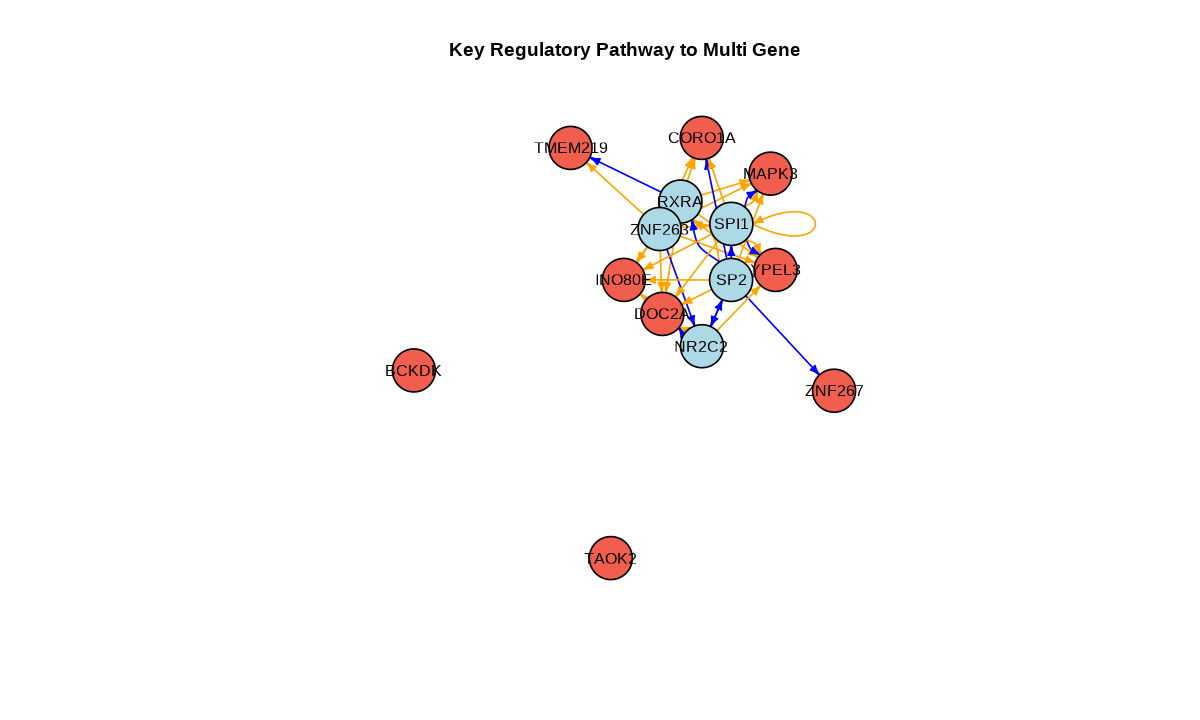

In [131]:
# Define nodes of interest
focus_gene <- multi_gene_list_name
core_nodes <- c("NR2C2", "ZNF263", "SP2", "SPI1", "RXRA", focus_gene)

# Create full network with edge attributes
reg_net <- df %>% dplyr::select(source = TF, target = TG, Regulation) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

# Filter subgraph with selected nodes
subg7 <- induced_subgraph(g, vids = V(g)[name %in% core_nodes])

# Set vertex color (focus genes in red)
V(subg7)$color <- ifelse(V(subg7)$name %in% focus_gene, '#F15E4E', "lightblue")

# Set edge color by regulation type
E(subg7)$color <- ifelse(E(subg7)$Regulation == "Repressing", "blue",
                        ifelse(E(subg7)$Regulation == "Activating", "orange", "gray"))

# Optional: adjust edge width by weight or use dashed lines for repressors
# E(subg)$lty <- ifelse(E(subg)$Regulation == "Repressing", 2, 1)

# Plot the graph
# pdf('./figs/GRN_multigene.pdf', width = 9.5, height = 16, family = "sans")

p12 <- plot(subg7,
     vertex.label.cex = 1,
     vertex.label.family = "sans",
     vertex.label.color = "black",
     vertex.color = V(subg7)$color,
     vertex.size = 20,
     edge.arrow.size = 0.5,
     edge.color = E(subg7)$color,
     layout = layout_with_fr(subg7),
     main = "Key Regulatory Pathway to Multi Gene")
p12

In [132]:
gene_df <- fread('/restricted/projectnb/xqtl/jaempawi/xqtl/multi_gene_share_contexts.txt')  #FIXME

In [133]:
# Prepare graph
reg_net <- df %>% dplyr::select(source = TF, target = TG, Regulation) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

# Define genes of interest
focus_gene <- gene_df$gene_name
core_nodes <- c("NR2C2", "ZNF263", "SP2", "SPI1", "RXRA", focus_gene)

# Subgraph
subg8 <- induced_subgraph(g, vids = V(g)[name %in% core_nodes])

In [134]:
# Set vertex color
V(subg8)$color <- ifelse(V(subg8)$name %in% focus_gene, '#F15E4E', "lightblue")

# Match dot size to n_all or other column
gene_size_map <- gene_df %>% dplyr::select(gene_name, n_count_sQTL1) %>% deframe()

NULL

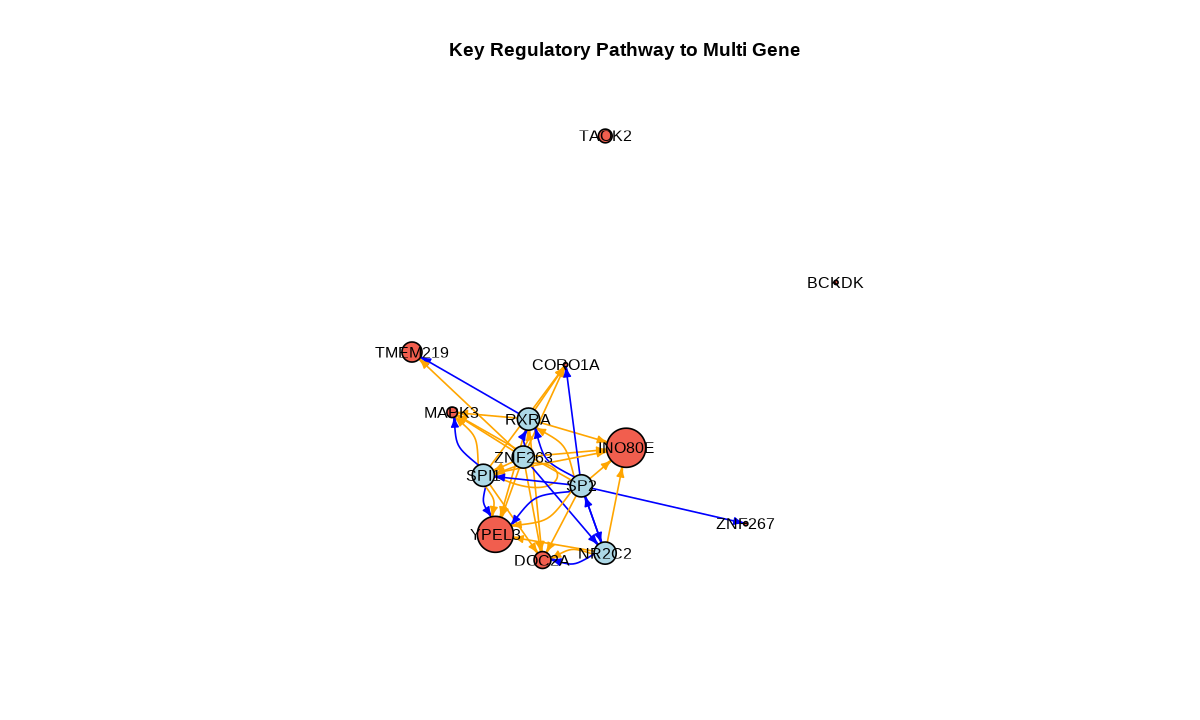

In [135]:
V(subg8)$size <- ifelse(V(subg8)$name %in% names(gene_size_map),
                       gene_size_map[V(subg8)$name] * 1.5, 10)  # adjust scale as needed

# Edge color by regulation
E(subg8)$color <- ifelse(E(subg8)$Regulation == "Repressing", "blue",
                        ifelse(E(subg8)$Regulation == "Activating", "orange", "gray"))

# Plot
# pdf('./figs/GRN_multigene.pdf', width = 10, height = 16, family = "sans")

p13 <- plot(subg8,
     vertex.label.cex = 1,
     vertex.label.family = "sans",
     vertex.label.color = "black",
     vertex.color = V(subg8)$color,
     vertex.size = V(subg8)$size,
     edge.arrow.size = 0.5,
     edge.color = E(subg8)$color,
     layout = layout_with_fr(subg8),
     main = "Key Regulatory Pathway to Multi Gene")
p13

In [136]:
cb <- fread('/restricted/projectnb/xqtl/jaempawi/xqtl/Staging/variant_gene_summary/AD_loci_summary/AD_xQTL_colocalization/AD_xQTL_colocboost_export_filtered.bed.gz')
cb %>% filter(gene_ID %in% gene_df$gene_ID)

#chr,start,end,a1,a2,variant_ID,gene_ID,event_ID,cos_ID,vcp,cos_npc,min_npc_outcome,coef
<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
16,29648903,29648905,C,T,chr16:29648905:T:C,ENSG00000149930,Kellis_Ast_ENSG00000149930; AD_Bellenguez,ENSG00000149930:cos1:y34_y55,0.15731266,0.5589,0.4728,0.00580717409251111;0.00178370917940764
16,29648903,29648905,C,T,chr16:29648905:T:C,ENSG00000149932,Kellis_Mic_ENSG00000149932; AD_Bellenguez,ENSG00000149932:cos2:y23_y36,0.24246126,0.8223,0.7876,-0.0231917908063331;0.00178356117441108
16,29649894,29649896,T,C,chr16:29649896:C:T,ENSG00000149930,Kellis_Ast_ENSG00000149930; AD_Bellenguez,ENSG00000149930:cos1:y34_y55,0.83172742,0.5589,0.4728,0.0353373888483476;0.00218527039761535
16,29649894,29649896,T,C,chr16:29649896:C:T,ENSG00000149932,Kellis_Mic_ENSG00000149932; AD_Bellenguez,ENSG00000149932:cos2:y23_y36,0.75168536,0.8223,0.7876,-0.0732775806809154;0.00218507518494286
16,29913099,29913101,T,A,chr16:29913101:A:T,ENSG00000149932,AC_lf2_sQTL_chr16:29962232:29963106:clu_110638_+:NE:ENSG00000149932; AC_lf2_sQTL_chr16:29962232:29963109:clu_110638_+:NE:ENSG00000149932; DLPFC_lf2_sQTL_chr16:29962232:29963109:clu_131719_+:NE:ENSG00000149932; DeJager_Ast_ENSG00000149932; Kellis_Ast_ENSG00000149932; Kellis_OPC_ENSG00000149932; PCC_lf2_sQTL_chr16:29962132:29962390:clu_101665_+:NE:ENSG00000149932; ROSMAP_AC_ENSG00000149932; ROSMAP_DLPFC_ENSG00000149932; AD_Bellenguez,ENSG00000149932:cos3:y3_y4_y6_y14_y20_y24_y29_y32_y33_y36,0.01255222,1.0000,0.4763,-0.000181029819259899;-0.00187553089732488;-5.83452183916351e-05;-0.000177289312998618;-0.00211298422809833;-9.38159324959302e-06;0.000738502411154741;-0.00404284995029416;-0.00109699925703438;1.98810503403778e-06
16,29913099,29913101,T,A,chr16:29913101:A:T,ENSG00000149932,AC_lf2_sQTL_chr16:29962232:29963106:clu_110638_+:NE:ENSG00000149932; AC_lf2_sQTL_chr16:29962232:29963109:clu_110638_+:NE:ENSG00000149932; DLPFC_lf2_sQTL_chr16:29962232:29963109:clu_131719_+:NE:ENSG00000149932; DeJager_Ast_ENSG00000149932; Kellis_Ast_ENSG00000149932; Kellis_OPC_ENSG00000149932; PCC_lf2_sQTL_chr16:29962132:29962390:clu_101665_+:NE:ENSG00000149932; ROSMAP_AC_ENSG00000149932; ROSMAP_DLPFC_ENSG00000149932; AD_Wightman_Full_2021,ENSG00000149932:cos3:y3_y4_y6_y14_y20_y24_y29_y32_y33_y36,0.01345728,1.0000,0.4902,-0.00016961027859452;-0.00179565367026293;-6.09122239689996e-05;-0.000173326287207139;-0.00210355385889389;-8.83992116558586e-06;0.000725860885255428;-0.00377344828907428;-0.000876214192570317;-3.54135631502978e-05
16,29913582,29913584,G,A,chr16:29913584:A:G,ENSG00000149932,AC_lf2_sQTL_chr16:29962232:29963106:clu_110638_+:NE:ENSG00000149932; AC_lf2_sQTL_chr16:29962232:29963109:clu_110638_+:NE:ENSG00000149932; DLPFC_lf2_sQTL_chr16:29962232:29963109:clu_131719_+:NE:ENSG00000149932; DeJager_Ast_ENSG00000149932; Kellis_Ast_ENSG00000149932; Kellis_OPC_ENSG00000149932; PCC_lf2_sQTL_chr16:29962132:29962390:clu_101665_+:NE:ENSG00000149932; ROSMAP_AC_ENSG00000149932; ROSMAP_DLPFC_ENSG00000149932; AD_Bellenguez,ENSG00000149932:cos3:y3_y4_y6_y14_y20_y24_y29_y32_y33_y36,0.03988393,1.0000,0.4763,-0.000197619750517417;-0.00424052143324231;-4.28374601670315e-05;-0.0106749980835483;-0.00887881248104837;-1.51544423515312e-06;0.00131710673284922;-0.00428943482718778;-0.0127293834396922;1.98680807742577e-06
16,29913582,29913584,G,A,chr16:29913584:A:G,ENSG00000149932,AC_lf2_sQTL_chr16:29962232:29963106:clu_110638_+:NE:ENSG00000149932; AC_lf2_sQTL_chr16:29962232:29963109:clu_110638_+:NE:ENSG00000149932; DLPFC_lf2_sQTL_chr16:29962232:29963109:clu_131719_+:NE:ENSG00000149932; DeJager_Ast_ENSG00000149932; Kellis_Ast_ENSG00000149932; Kellis_OPC_ENSG00000149932; PCC_lf2_sQTL_chr16:29962132:29962390:clu_101665_+:NE:ENSG00000149932; ROSMAP_AC_ENSG00000149932; ROSMAP_DLPFC_ENSG00000149932; AD_Wightman_Full_2021,ENSG00000149932:cos3:y3_y4_y6_y14_y20_y24_y29_y32_y33_y36,0.04219279,1.0000,0.4902,-0.000185098918477567;-0.00399433567174669;-4.48486912799211e-05;-0.01057326203

### Multigene GRN - STX4

In [137]:
df <- readRDS('/restricted/projectnb/xqtl/jaempawi/xqtl/all_GRN.rds') #FIXME
reg_net <- unique(df[, .(source = TF, target = TG)])
g <- graph_from_data_frame(reg_net, directed = TRUE)


multi_gene_list_name <- c('STX4', 'KAT8', 'PRSS36')
valid_genes <- multi_gene_list_name[multi_gene_list_name %in% V(g)$name]

tf_genes2 <- list()
for (gene in valid_genes) {
  neighbors_g <- ego(g, order = 1, nodes = gene, mode = "in")[[1]]
  tf_genes2[[gene]] <- setdiff(names(neighbors_g), gene)
}

In [138]:
Reduce(intersect, tf_genes2)

[1] "IRF1"   "ESR1"   "FOXP1"  "MEF2A"  "PBX3"   "MAFK"   "ZNF460" "MEF2C" 
 [9] "SREBF1" "RARG"   "ZNF140" "ZNF135" "PKNOX1" "ZNF740"

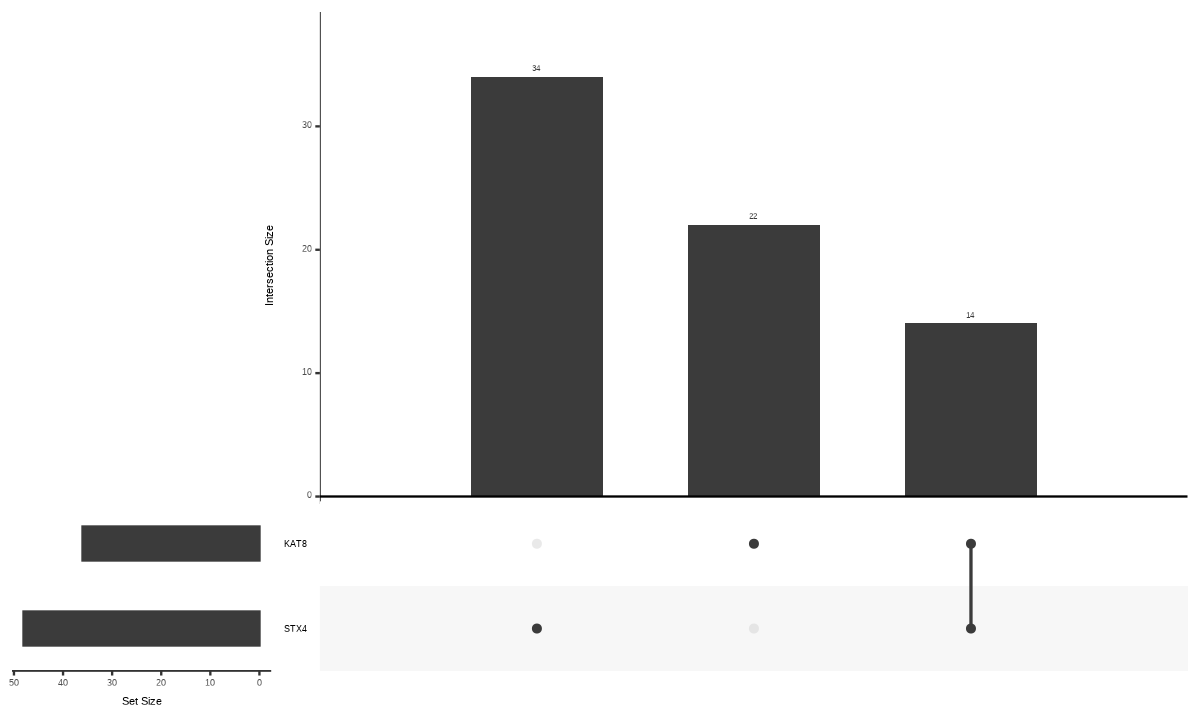

In [139]:
# Convert list to binary presence/absence data frame
gene_matrix2 <- fromList(tf_genes2)

# Create the UpSet plot
p14 <- upset(gene_matrix2, sets = names(tf_genes2), order.by = "freq")
p14

In [140]:
tf_genes

$YPEL3
 [1] "NR2F1"   "ESR1"    "CREB3L1" "JUN"     "ATF2"    "JUND"    "BACH1"  
 [8] "RXRA"    "THRB"    "ZNF148"  "MAFK"    "TP53"    "PPARD"   "FOXK1"  
[15] "ZNF263"  "NFYB"    "SP2"     "FOS"     "RARA"    "BACH2"   "RREB1"  
[22] "IRF2"    "SPI1"    "NR2C2"   "KLF13"   "NR1H2"   "RXRB"    "ZNF135" 
[29] "PPARA"   "EGR1"    "NFIB"    "PKNOX2"  "NR6A1"   "PKNOX1"  "ASCL1"  
[36] "PPARG"   "SMAD3"   "ZNF684"  "NFYA"    "SMAD2"   "SMAD4"   "SP1"    
[43] "MAZ"     "IRF9"    "POU2F2"  "ZNF274"  "ATF6"    "ZNF449"  "INSM1"  
[50] "PURA"    "NPDC1"  

$INO80E
 [1] "RXRG"    "ESR1"    "ELF1"    "RXRA"    "TEAD1"   "PLAG1"   "ZBTB26" 
 [8] "ZNF263"  "TCF7L1"  "ZBTB6"   "TCF7L2"  "SP2"     "NR1D1"   "RARA"   
[15] "HNF4G"   "NR1D2"   "IRF3"    "IRF2"    "SPI1"    "NR2C2"   "NR3C1"  
[22] "REST"    "YY1"     "NR6A1"   "PKNOX1"  "ASCL1"   "ZKSCAN5" "HSF1"   
[29] "IRF9"    "SCRT1"   "ETV1"    "SRF"     "GLIS2"   "RELA"   

$DOC2A
 [1] "NR2F1"   "IRF1"    "ZBTB7A"  "ZNF528"  "JUN"     "SP3"     "MAFG"   
 [8] "JUND"    "BACH1"   "STAT1"   "FOXP1"   "RXRA"    "MEF2A"   "RFX5"   
[15] "POU3F3"  "ZNF148"  "RFX3"    "STAT2"   "NFIC"    "MAFK"    "SP4"    
[22] "ZNF460"  "SOX4"    "ZNF384"  "E2F6"    "ZNF263"  "SP2"     "ZNF682" 
[29] "FOS"     "PRDM1"   "SREBF1"  "NR1D1"   "RFX2"    "NR1D2"   "BACH2"  
[36] "RREB1"   "SPI1"    "NR2C2"   "KLF13"   "MEF2D"   "ZNF135"  "EGR1"   
[43] "MAF"     "GABPA"   "SP1"     "MAZ"     "JUNB"    "RFX4"    "KLF16"  
[50] "RFX1"    "NEUROD1" "SP9"     "ZNF75D"  "INSM1"   "FOXO1"   "MGA"    
[57] "ZNF75A"  "WT1"     "PURA"    "NR0B1"   "KLF4"    "MEIS3"   "MYOD1"  
[64] "FERD3L"  "TAL1"    "TAL2"    "NFE2"    "ZNF219"  "KLF1"    "GTF2F1" 
[71] "ETS2"    "EPAS1"   "EOMES"   "PGR"     "NFAT5"   "TBX10"   "ZNF75C" 

$MAPK3
 [1] "RXRG"    "NR2F1"   "IRF1"    "KLF15"   "JUN"     "MAFG"    "CEBPG"  
 [8] "ATF4"    "STAT1"   "FOXP1"   "RXRA"    "MEF2A"   "USF2"    "THRB"   
[15] "PBX3"    "NFIC"    "SP4"     "ZNF460"  "ZNF384"  "E2F6"    "ZNF263" 
[22] "SP2"     "MEF2C"   "PRDM1"   "RARG"    "RARA"    "IRF3"    "SPI1"   
[29] "KLF13"   "MEF2D"   "RXRB"    "EGR1"    "NR3C1"   "NFIB"    "PKNOX2" 
[36] "SMAD3"   "SMAD2"   "CEBPA"   "ZNF382"  "SP1"     "MAZ"     "RARB"   
[43] "MITF"    "BHLHE41" "USF1"    "CEBPD"   "ELF2"    "RELA"    "ETV6"   
[50] "ZNF76"   "RUNX1"   "ETS2"    "ELF5"    "SPIB"    "ZNF683"  "ATF5"   
[57] "SPIC"   

$CORO1A
 [1] "RXRG"            "NR2F1"           "IRF1"            "ELF1"           
 [5] "ONECUT2"         "JUN"             "ATF2"            "JUND"           
 [9] "CEBPG"           "BACH1"           "STAT1"           "FOXP1"          
[13] "RXRA"            "MEF2A"           "USF2"            "STAT2"          
[17] "NFIC"            "EBF1"            "MAFK"            "PLAG1"          
[21] "MEF2B"           "FOXK1"           "ZBTB26"          "ZNF384"         
[25] "ZNF263"          "SP2"             "ZNF682"          "XBP1"           
[29] "FOS"             "MEF2C"           "PRDM1"           "SREBF1"         
[33] "NR1D1"           "RARA"            "BACH2"           "IRF3"           
[37] "RREB1"           "SPI1"            "MEF2D"           "ZNF135"         
[41] "PPARA"           "NFIB"            "REST"            "AR"             
[45] "NR6A1"           "MAF"             "PKNOX1"          "SMAD3"          
[49] "ZNF684"          "RUNX2"           "SMAD2"           "MAZ"            
[53] "IRF9"            "SCRT1"           "NR4A1"           "ELF2"           
[57] "STAT3"           "ETV6"            "CEBPB"           "PML"            
[61] "BCL11A"          "NR2C1"           "ETS2"            "KLF2"           
[65] "ELF5"            "ARID3A"          "SPIB"            "BCL11B"         
[69] "ENSG00000250096" "IRF4"            "ATF5"            "SPIC"           

$BCKDK
[1] "ZNF148" "MAZ"    "PURA"  

$ZNF267
 [1] "IRF1"   "ESR1"   "STAT1"  "MZF1"   "SP4"    "SP2"    "PRDM1"  "RREB1" 
 [9] "IRF2"   "NFIB"   "YY1"    "SMAD2"  "IKZF1"  "ZNF75D" "PML"    "ETV3"  
[17] "REL"   

$

NULL

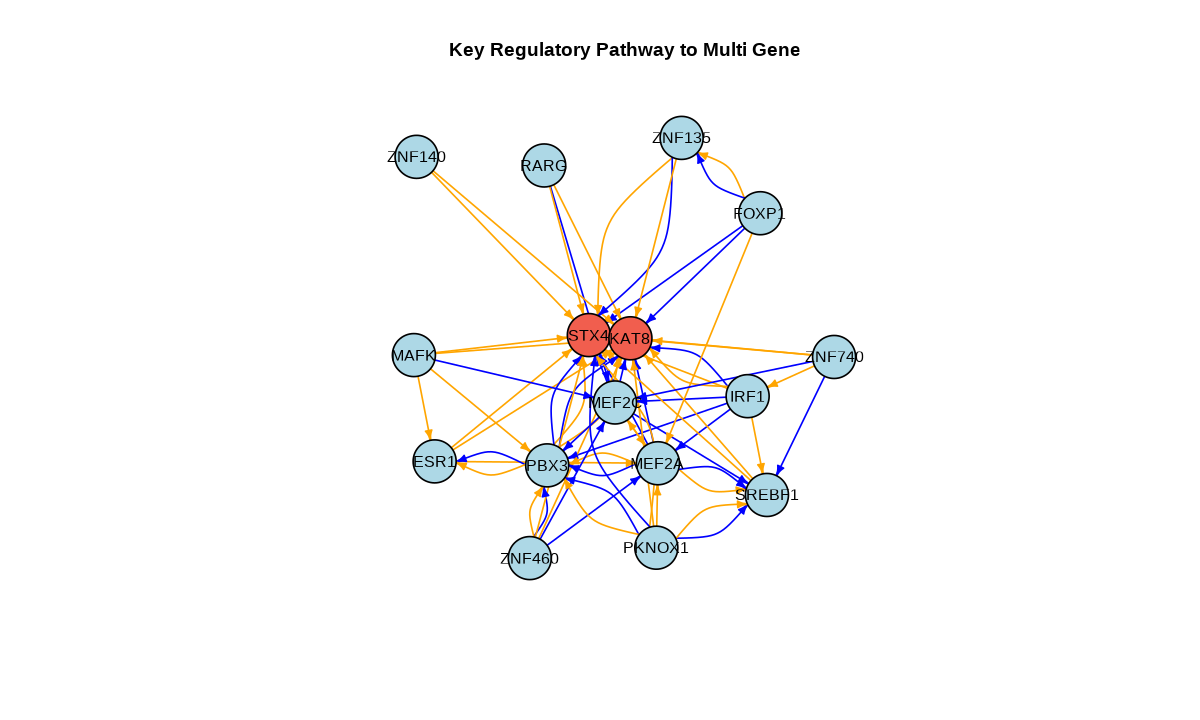

In [142]:
# Define nodes of interest
focus_gene <- multi_gene_list_name
core_nodes <- c(Reduce(intersect, tf_genes2), focus_gene)

# Create full network with edge attributes
reg_net <- df %>% dplyr::select(source = TF, target = TG, Regulation) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

# Filter subgraph with selected nodes
subg9 <- induced_subgraph(g, vids = V(g)[name %in% core_nodes])

# Set vertex color (focus genes in red)
V(subg9)$color <- ifelse(V(subg9)$name %in% focus_gene, '#F15E4E', "lightblue")

# Set edge color by regulation type
E(subg9)$color <- ifelse(E(subg9)$Regulation == "Repressing", "blue",
                        ifelse(E(subg9)$Regulation == "Activating", "orange", "gray"))

# Optional: adjust edge width by weight or use dashed lines for repressors
# E(subg)$lty <- ifelse(E(subg)$Regulation == "Repressing", 2, 1)

# Plot the graph
# pdf('./figs/GRN_multigene_STX4.pdf', width = 9.5, height = 16, family = "sans")

p15 <- plot(subg9,
     vertex.label.cex = 1,
     vertex.label.family = "sans",
     vertex.label.color = "black",
     vertex.color = V(subg9)$color,
     vertex.size = 20,
     edge.arrow.size = 0.5,
     edge.color = E(subg9)$color,
     layout = layout_with_fr(subg9),
     main = "Key Regulatory Pathway to Multi Gene")
p15